In [1]:
# --------------------------------------------------------------------
## Import Libraries
# --------------------------------------------------------------------


import numpy as np
from pathlib import Path
import sys
import pickle
import configparser

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f as f_dist

# from sklearn.linear_model import Lasso, LassoCV
# from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
## File Paths
# -----------------------------

# Current Directory
current_dir = Path.cwd()
# Top Directory (for .py it is same as current_dir, for .ipynb it is one level up)
    # Sometimes use .parern( for ipynb and .py in oracle cloud), someimes use nothing (.py on windows)
top_dir = current_dir.parent if current_dir.name == '4-Correlations' else current_dir

# Libs Directory
libs_dir = str(top_dir / "0-Libs")
# Config
config_dir = top_dir / "0-Config"

# Data Directory
data_dir = top_dir / "0-Data"   
    # HighRes (0)
highres_dir = str(data_dir / "0-HighRes")
    # Routine (1)
routine_dir = str(data_dir / "1-Routine")
    # Active (2)
active_dir = str(data_dir / "2-Active")
    # LongActive (3)
long_active_dir = str(data_dir / "3-LongActive")
    # LongRoutine (4)
long_routine_dir = str(data_dir / "4-LongRoutine")


# Sensitivity Results Directory
sensitivity_results_dir = top_dir / "2-Sensitivity" / "Results"

# -----------------------------
## Import Libraries - Custom
# -----------------------------
sys.path.append(libs_dir)

from plant_config import get_reactor_initial_values
from asm3_model import ode_system_wrapper

# -----------------------------
## Configs
# -----------------------------

# Config File
config = configparser.ConfigParser()
config.read(config_dir / "config.ini")
   # Seed for random number generator
seed = int(config['OVERALL']['seed'])
np.random.seed(seed)                         # Set random seed
data_to_use_for_identifiability = str(config['OVERALL']['data_to_use_for_run'])
    # True theta params
true_param_k_H = float(config['TRUEPARAMS']['true_param_k_H'])              # True k_H
true_param_K_X = float(config['TRUEPARAMS']['true_param_K_X'])              # True K_X
true_param_k_STO = float(config['TRUEPARAMS']['true_param_small_k_STO'])          # True k_STO
true_param_eta_NOX = float(config['TRUEPARAMS']['true_param_eta_NOX'])      # True eta_NOX
true_param_K_O2 = float(config['TRUEPARAMS']['true_param_K_O2'])            # True K_O2
true_param_K_NOX = float(config['TRUEPARAMS']['true_param_K_NOX'])          # True K_NOX
true_param_K_S = float(config['TRUEPARAMS']['true_param_K_S'])              # True K_S
true_param_K_STO = float(config['TRUEPARAMS']['true_param_big_K_STO'])          # True K_STO
true_param_mu_H = float(config['TRUEPARAMS']['true_param_mu_H'])            # True mu_H
true_param_K_NH4 = float(config['TRUEPARAMS']['true_param_K_NH4'])          # True K_NH4
true_param_K_ALK = float(config['TRUEPARAMS']['true_param_K_ALK'])          # True K_ALK
true_param_b_H_O2 = float(config['TRUEPARAMS']['true_param_b_H_O2'])        # True b_H_O2
true_param_b_H_NOX = float(config['TRUEPARAMS']['true_param_b_H_NOX'])      # True b_H_NOX
true_param_b_STO_O2 = float(config['TRUEPARAMS']['true_param_b_STO_O2'])    # True b_STO_O2
true_param_b_STO_NOX = float(config['TRUEPARAMS']['true_param_b_STO_NOX'])  # True b_STO_NOX
true_param_mu_A = float(config['TRUEPARAMS']['true_param_mu_A'])            # True mu_A
true_param_K_A_NH4 = float(config['TRUEPARAMS']['true_param_K_A_NH4'])      # True K_A_NH4
true_param_K_A_O2 = float(config['TRUEPARAMS']['true_param_K_A_O2'])        # True K_A_O2
true_param_K_A_ALK = float(config['TRUEPARAMS']['true_param_K_A_ALK'])      # True K_A_ALK
true_param_b_A_O2 = float(config['TRUEPARAMS']['true_param_b_A_O2'])        # True b_A_O2
true_param_b_A_NOX = float(config['TRUEPARAMS']['true_param_b_A_NOX'])      # True b_A_NOX
true_param_f_S_I = float(config['TRUEPARAMS']['true_param_f_S_I'])          # True f_S_I
true_param_Y_STO_O2 = float(config['TRUEPARAMS']['true_param_Y_STO_O2'])    # True Y_STO_O2
true_param_Y_STO_NOX = float(config['TRUEPARAMS']['true_param_Y_STO_NOX'])  # True Y_STO_NOX
true_param_Y_H_O2 = float(config['TRUEPARAMS']['true_param_Y_H_O2'])        # True Y_H_O2
true_param_Y_H_NOX = float(config['TRUEPARAMS']['true_param_Y_H_NOX'])      # True Y_H_NOX
true_param_Y_A = float(config['TRUEPARAMS']['true_param_Y_A'])              # True Y_A
true_param_f_X_I = float(config['TRUEPARAMS']['true_param_f_X_I'])          # True f_X_I
true_param_i_N_S_I = float(config['TRUEPARAMS']['true_param_i_N_S_I'])      # True i_N_S_I
true_param_i_N_S_S = float(config['TRUEPARAMS']['true_param_i_N_S_S'])      # True i_N_S_S
true_param_i_N_X_I = float(config['TRUEPARAMS']['true_param_i_N_X_I'])      # True i_N_X_I
true_param_i_N_X_S = float(config['TRUEPARAMS']['true_param_i_N_X_S'])      # True i_N_X_S
true_param_i_N_BM = float(config['TRUEPARAMS']['true_param_i_N_BM'])        # True i_N_BM
true_param_i_SS_X_I = float(config['TRUEPARAMS']['true_param_i_SS_X_I'])    # True i_SS_X_I
true_param_i_SS_X_S = float(config['TRUEPARAMS']['true_param_i_SS_X_S'])    # True i_SS_X_S
true_param_i_SS_BM = float(config['TRUEPARAMS']['true_param_i_SS_BM'])      # True i_SS_BM
    # Reactor volumes
r1_V = float(config['REACTOR']['r1_V'])        # Volume of reactor 1

NAASI_threshold = float(config['IDENTIFIABILITY']['NAASI_threshold'])  # NAASI threshold for identifiability

# ----------------------------------------------------------
# TODO: from config or data
# Other Configs
solver_method='BDF'

# ----------------------------------------------------------
## Load Data from csv
# ----------------------------------------------------------

    # Highres (0)
data_highres_influent_states = pd.read_csv(highres_dir + "/HighRes_Influent_States.csv")
data_highres_effluent_states = pd.read_csv(highres_dir + "/HighRes_Effluent_States.csv")
    # Routine (1)
data_routine_influent_states = pd.read_csv(routine_dir + "/Routine_Influent_States.csv")
data_routine_effluent_states = pd.read_csv(routine_dir + "/Routine_Effluent_States.csv")
    # Active (2)
data_active_influent_states = pd.read_csv(active_dir + "/Active_Influent_States.csv")
data_active_effluent_states = pd.read_csv(active_dir + "/Active_Effluent_States.csv")
    # LongActive (3)
data_longactive_influent_states = pd.read_csv(long_active_dir + "/LongActive_Influent_States.csv")
data_longactive_effluent_states = pd.read_csv(long_active_dir + "/LongActive_Effluent_States.csv")
    # LongRoutine (4)
data_longroutine_influent_states = pd.read_csv(long_routine_dir + "/LongRoutine_Influent_States.csv")
data_longroutine_effluent_states = pd.read_csv(long_routine_dir + "/LongRoutine_Effluent_States.csv")


# ----------------------------------------------------------
## Data to use for identifiability
# ----------------------------------------------------------

data_mapping_influent = {
    'HighRes': data_highres_influent_states,
    'Routine': data_routine_influent_states,
    'Active': data_active_influent_states,
    'LongActive': data_longactive_influent_states,
    'LongRoutine': data_longroutine_influent_states,
}
data_mapping_effluent = {
    'HighRes': data_highres_effluent_states,
    'Routine': data_routine_effluent_states,
    'Active': data_active_effluent_states,
    'LongActive': data_longactive_effluent_states,
    'LongRoutine': data_longroutine_effluent_states,
}

try:
    Data_Influent = data_mapping_influent[data_to_use_for_identifiability]
    Data_Effluent = data_mapping_effluent[data_to_use_for_identifiability]
except KeyError:
    raise ValueError("Invalid data for sanpling. Choose from HighRes, Routine, LongRoutine, HalfActive (Deprecated), Active, or LongActive.")


In [2]:
# ----------------------------------------------------------
## Import from Identifiability Results
# ----------------------------------------------------------

# Get ProfileLikelihoodResults.pkl from '3-Identifiability/Results/ProfileLikelihoodResults.pkl'
ProfileLikelihoodResults = pd.read_pickle(str(top_dir / "3-Identifiability" / "Results" / "ProfileLikelihoodResults.pkl"))


In [3]:
# ----------------------------------------------------------
## Parameters
# ----------------------------------------------------------


theta_true = {
    'k_H': true_param_k_H,
    'K_X': true_param_K_X,
    'k_STO': true_param_k_STO,
    'eta_NOX': true_param_eta_NOX,
    'K_O2': true_param_K_O2,
    'K_NOX': true_param_K_NOX,
    'K_S': true_param_K_S,
    'K_STO': true_param_K_STO,
    'mu_H': true_param_mu_H,
    'K_NH4': true_param_K_NH4,
    'K_ALK': true_param_K_ALK,
    'b_H_O2': true_param_b_H_O2,
    'b_H_NOX': true_param_b_H_NOX,
    'b_STO_O2': true_param_b_STO_O2,
    'b_STO_NOX': true_param_b_STO_NOX,
    'mu_A': true_param_mu_A,
    'K_A_NH4': true_param_K_A_NH4,
    'K_A_O2': true_param_K_A_O2,
    'K_A_ALK': true_param_K_A_ALK,
    'b_A_O2': true_param_b_A_O2,
    'b_A_NOX': true_param_b_A_NOX,
    'f_S_I': true_param_f_S_I,
    'Y_STO_O2': true_param_Y_STO_O2,
    'Y_STO_NOX': true_param_Y_STO_NOX,
    'Y_H_O2': true_param_Y_H_O2,
    'Y_H_NOX': true_param_Y_H_NOX,
    'Y_A': true_param_Y_A,
    'f_X_I': true_param_f_X_I,
    'i_N_S_I': true_param_i_N_S_I,
    'i_N_S_S': true_param_i_N_S_S,
    'i_N_X_I': true_param_i_N_X_I,
    'i_N_X_S': true_param_i_N_X_S,
    'i_N_BM': true_param_i_N_BM,
    'i_SS_X_I': true_param_i_SS_X_I,
    'i_SS_X_S': true_param_i_SS_X_S,
    'i_SS_BM': true_param_i_SS_BM,
}

all_param_idx = {
    'k_H': 0,
    'K_X': 1,
    'k_STO': 2,
    'eta_NOX': 3,
    'K_O2': 4,
    'K_NOX': 5,
    'K_S': 6,
    'K_STO': 7,
    'mu_H': 8,
    'K_NH4': 9,
    'K_ALK': 10,
    'b_H_O2': 11,
    'b_H_NOX': 12,
    'b_STO_O2': 13,
    'b_STO_NOX': 14,
    'mu_A': 15,
    'K_A_NH4': 16,
    'K_A_O2': 17,
    'K_A_ALK': 18,
    'b_A_O2': 19,
    'b_A_NOX': 20,
    'f_S_I': 21,
    'Y_STO_O2': 22,
    'Y_STO_NOX': 23,
    'Y_H_O2': 24,
    'Y_H_NOX': 25,
    'Y_A': 26,
    'f_X_I': 27,
    'i_N_S_I': 28,
    'i_N_S_S': 29,
    'i_N_X_I': 30,
    'i_N_X_S': 31,
    'i_N_BM': 32,
    'i_SS_X_I': 33,
    'i_SS_X_S': 34,
    'i_SS_BM': 35
}
num_params = len(all_param_idx)

theta_format_names = {
    'k_H': r'$k_H$',
    'K_X': r'$K_X$',
    'k_STO': r'$k_{STO}$',
    'eta_NOX': r'$\eta_{NOX}$',
    'K_O2': r'$K_{O2}$',
    'K_NOX': r'$K_{NOX}$',
    'K_S': r'$K_S$',
    'K_STO': r'$K_{STO}$',
    'mu_H': r'$\mu_H$',
    'K_NH4': r'$K_{NH4}$',
    'K_ALK': r'$K_{ALK}$',
    'b_H_O2': r'$b_{H,O2}$',
    'b_H_NOX': r'$b_{H,NOX}$',
    'b_STO_O2': r'$b_{STO,O2}$',
    'b_STO_NOX': r'$b_{STO,NOX}$',
    'mu_A': r'$\mu_A$',
    'K_A_NH4': r'$K_{A,NH4}$',
    'K_A_O2': r'$K_{A,O2}$',
    'K_A_ALK': r'$K_{A,ALK}$',
    'b_A_O2': r'$b_{A,O2}$',
    'b_A_NOX': r'$b_{A,NOX}$',
    'f_S_I': r'$f_{S,I}$',
    'Y_STO_O2': r'$Y_{STO,O2}$',
    'Y_STO_NOX': r'$Y_{STO,NOX}$',
    'Y_H_O2': r'$Y_{H,O2}$',
    'Y_H_NOX': r'$Y_{H,NOX}$',
    'Y_A': r'$Y_A$',
    'f_X_I': r'$f_{X,I}$',
    'i_N_S_I': r'$i_{N,S,I}$',
    'i_N_S_S': r'$i_{N,S,S}$',
    'i_N_X_I': r'$i_{N,X,I}$',
    'i_N_X_S': r'$i_{N,X,S}$',
    'i_N_BM': r'$i_{N,BM}$',
    'i_SS_X_I': r'$i_{SS,X,I}$',
    'i_SS_X_S': r'$i_{SS,X,S}$',
    'i_SS_BM': r'$i_{SS,BM}$'
}

NAASI_results = pd.read_csv(sensitivity_results_dir / 'NAASI_combined.csv')
NAASI_results = NAASI_results.set_index('Parameter')
# Get parameters with NAASI values below threshold
params_to_always_fix = {
    param: theta_true[param] for param in NAASI_results.index if NAASI_results.loc[param, 'NAASI'] < NAASI_threshold
}
# Print the parameters to always fix based on NAASI results 
print(f'Parameters to always fix based on NAASI results (Param, fixed value):')
for param, fixed_val in params_to_always_fix.items():
    print(f'    {param}:    {fixed_val}')

# Sort params_to_always_fix by their index in all_param_idx
params_to_always_fix = dict(sorted(params_to_always_fix.items(), key=lambda item: all_param_idx[item[0]]))


Parameters to always fix based on NAASI results (Param, fixed value):
    i_SS_BM:    0.9
    i_SS_X_I:    0.75
    i_SS_X_S:    0.75
    f_S_I:    1e-06
    K_NH4:    0.01
    i_N_S_I:    0.01
    i_N_X_I:    0.04
    i_N_S_S:    0.03
    K_ALK:    0.1
    K_STO:    0.1
    b_A_NOX:    0.1
    b_STO_NOX:    0.15
    i_N_X_S:    0.03
    b_H_NOX:    0.15
    f_X_I:    0.2
    b_A_O2:    0.2
    i_N_BM:    0.07
    K_O2:    0.2
    b_STO_O2:    0.3
    b_H_O2:    0.3


----------------------------------
Profile Likelihood for k_H
----------------------------------


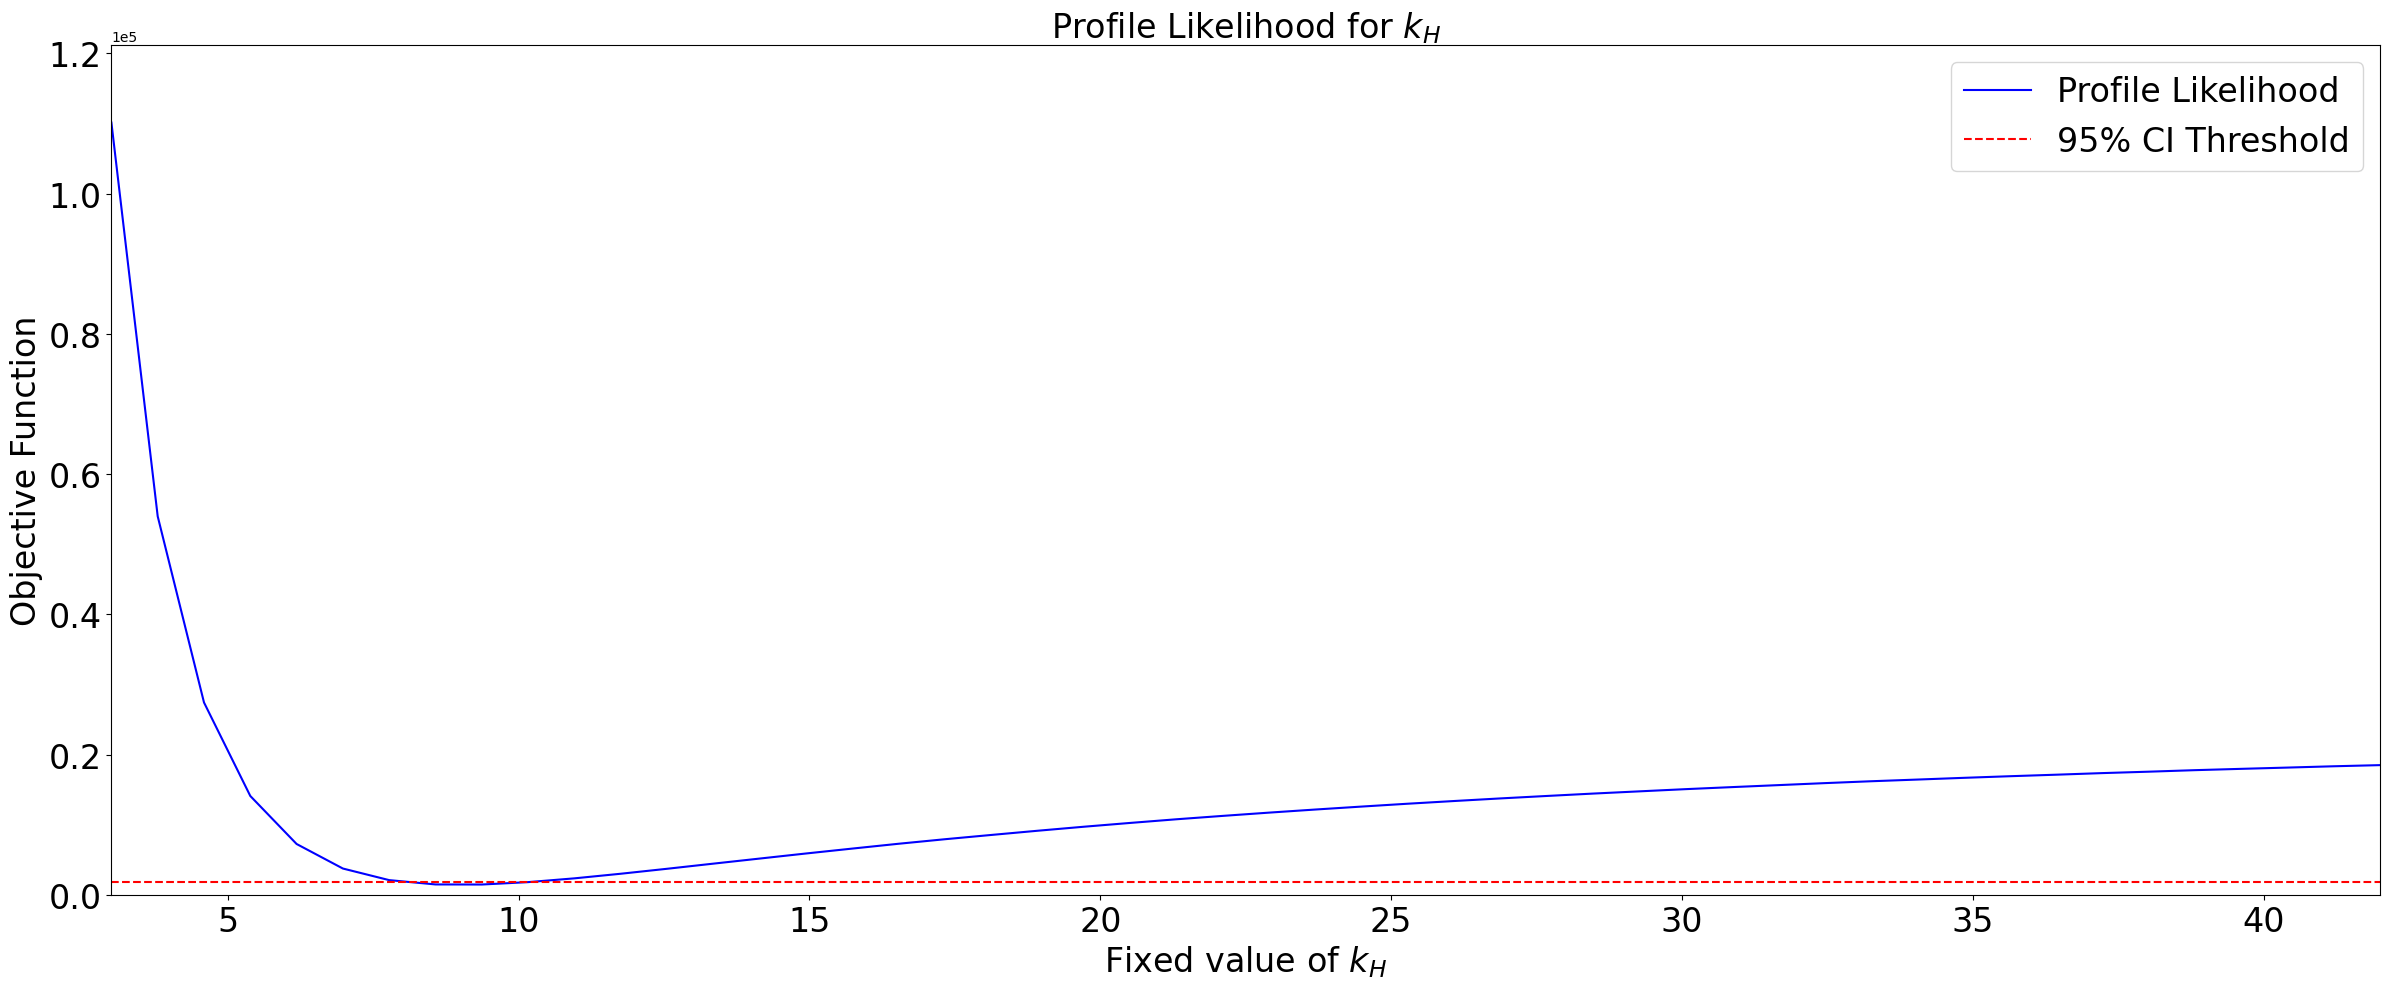

----------------------------------
Profile Likelihood for K_X
----------------------------------


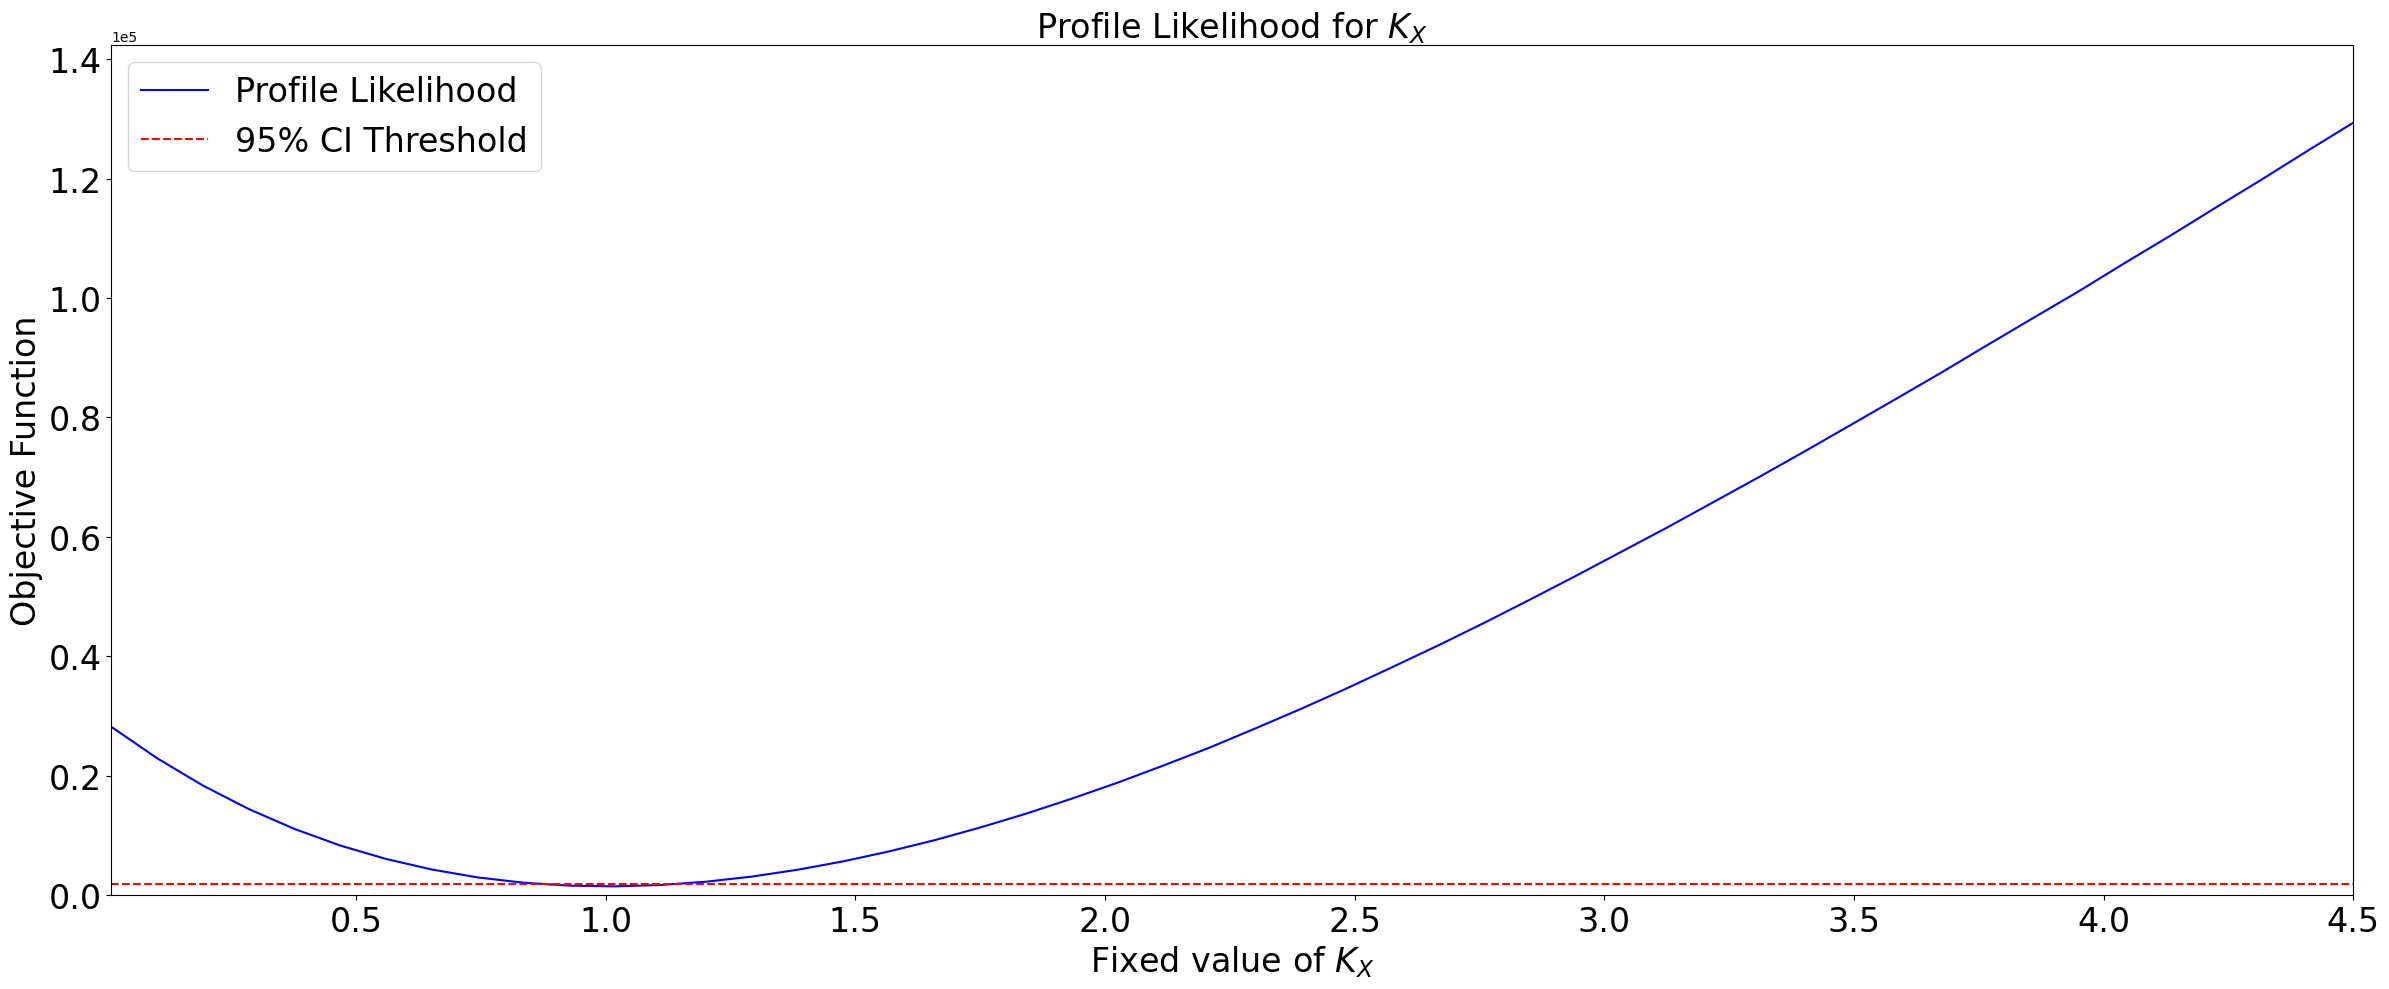

----------------------------------
Profile Likelihood for k_STO
----------------------------------


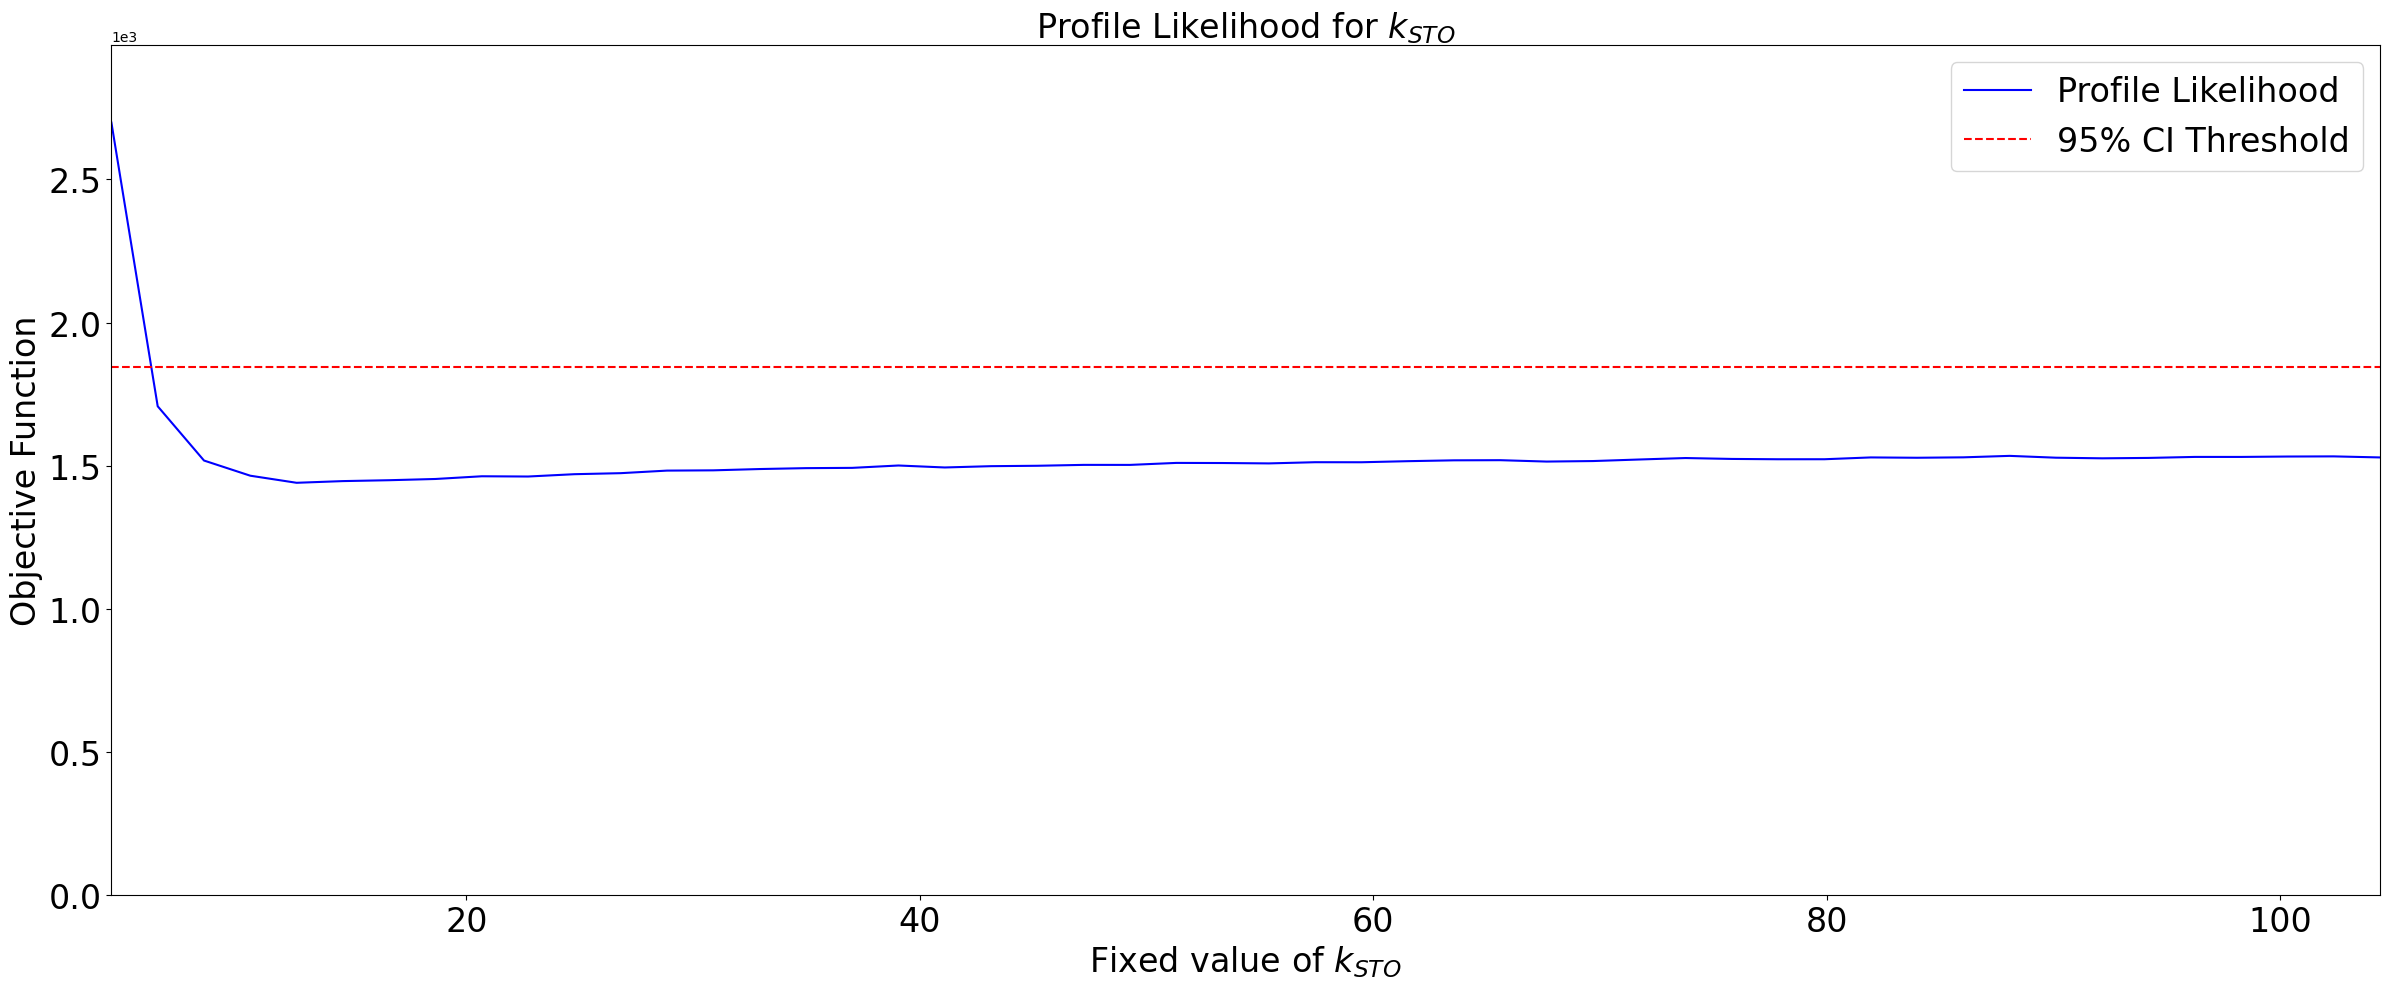

----------------------------------
Profile Likelihood for eta_NOX
----------------------------------


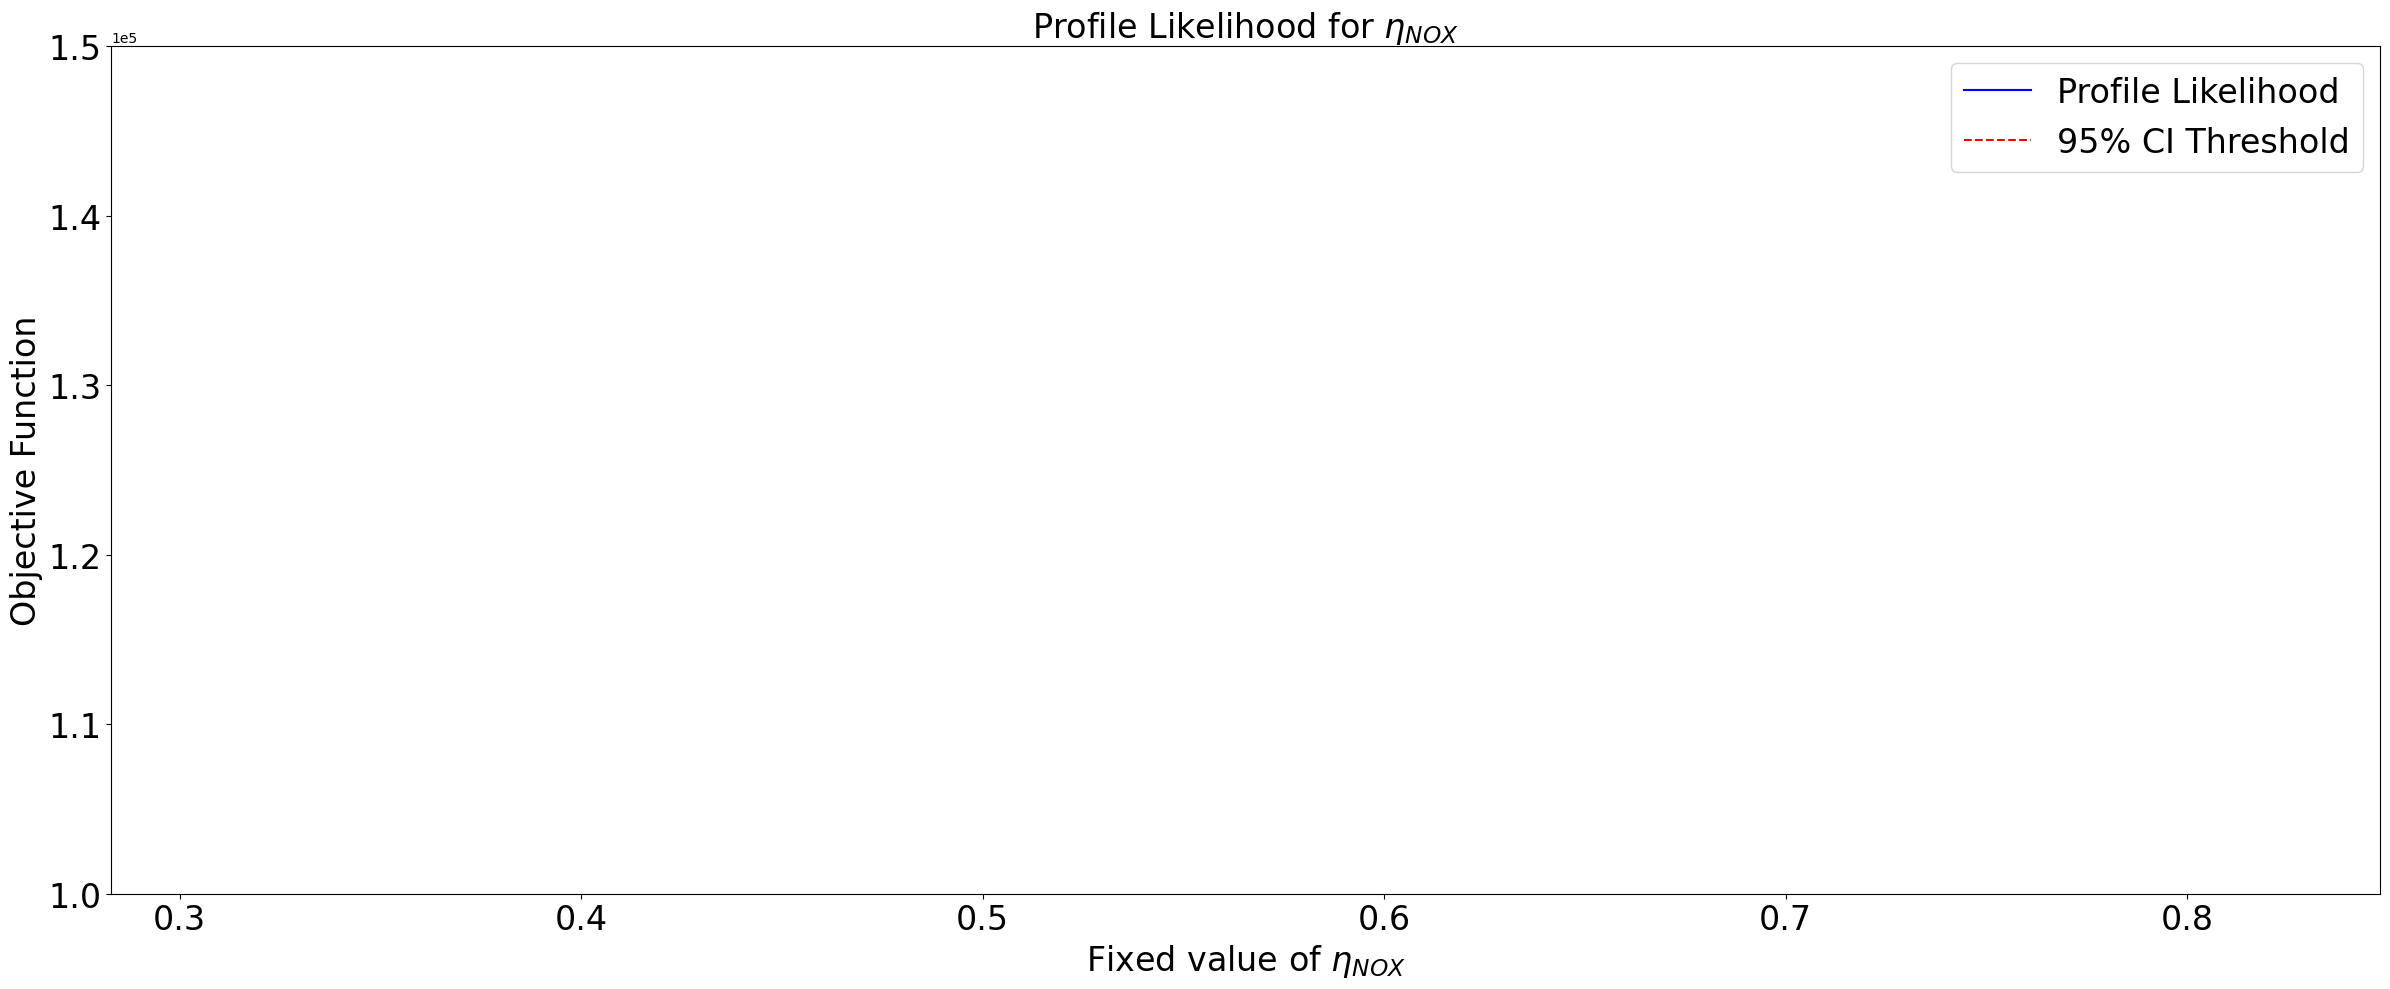

K_O2 is always fixed to [0.2], skipping profile likelihood plot.
----------------------------------
Profile Likelihood for K_NOX
----------------------------------


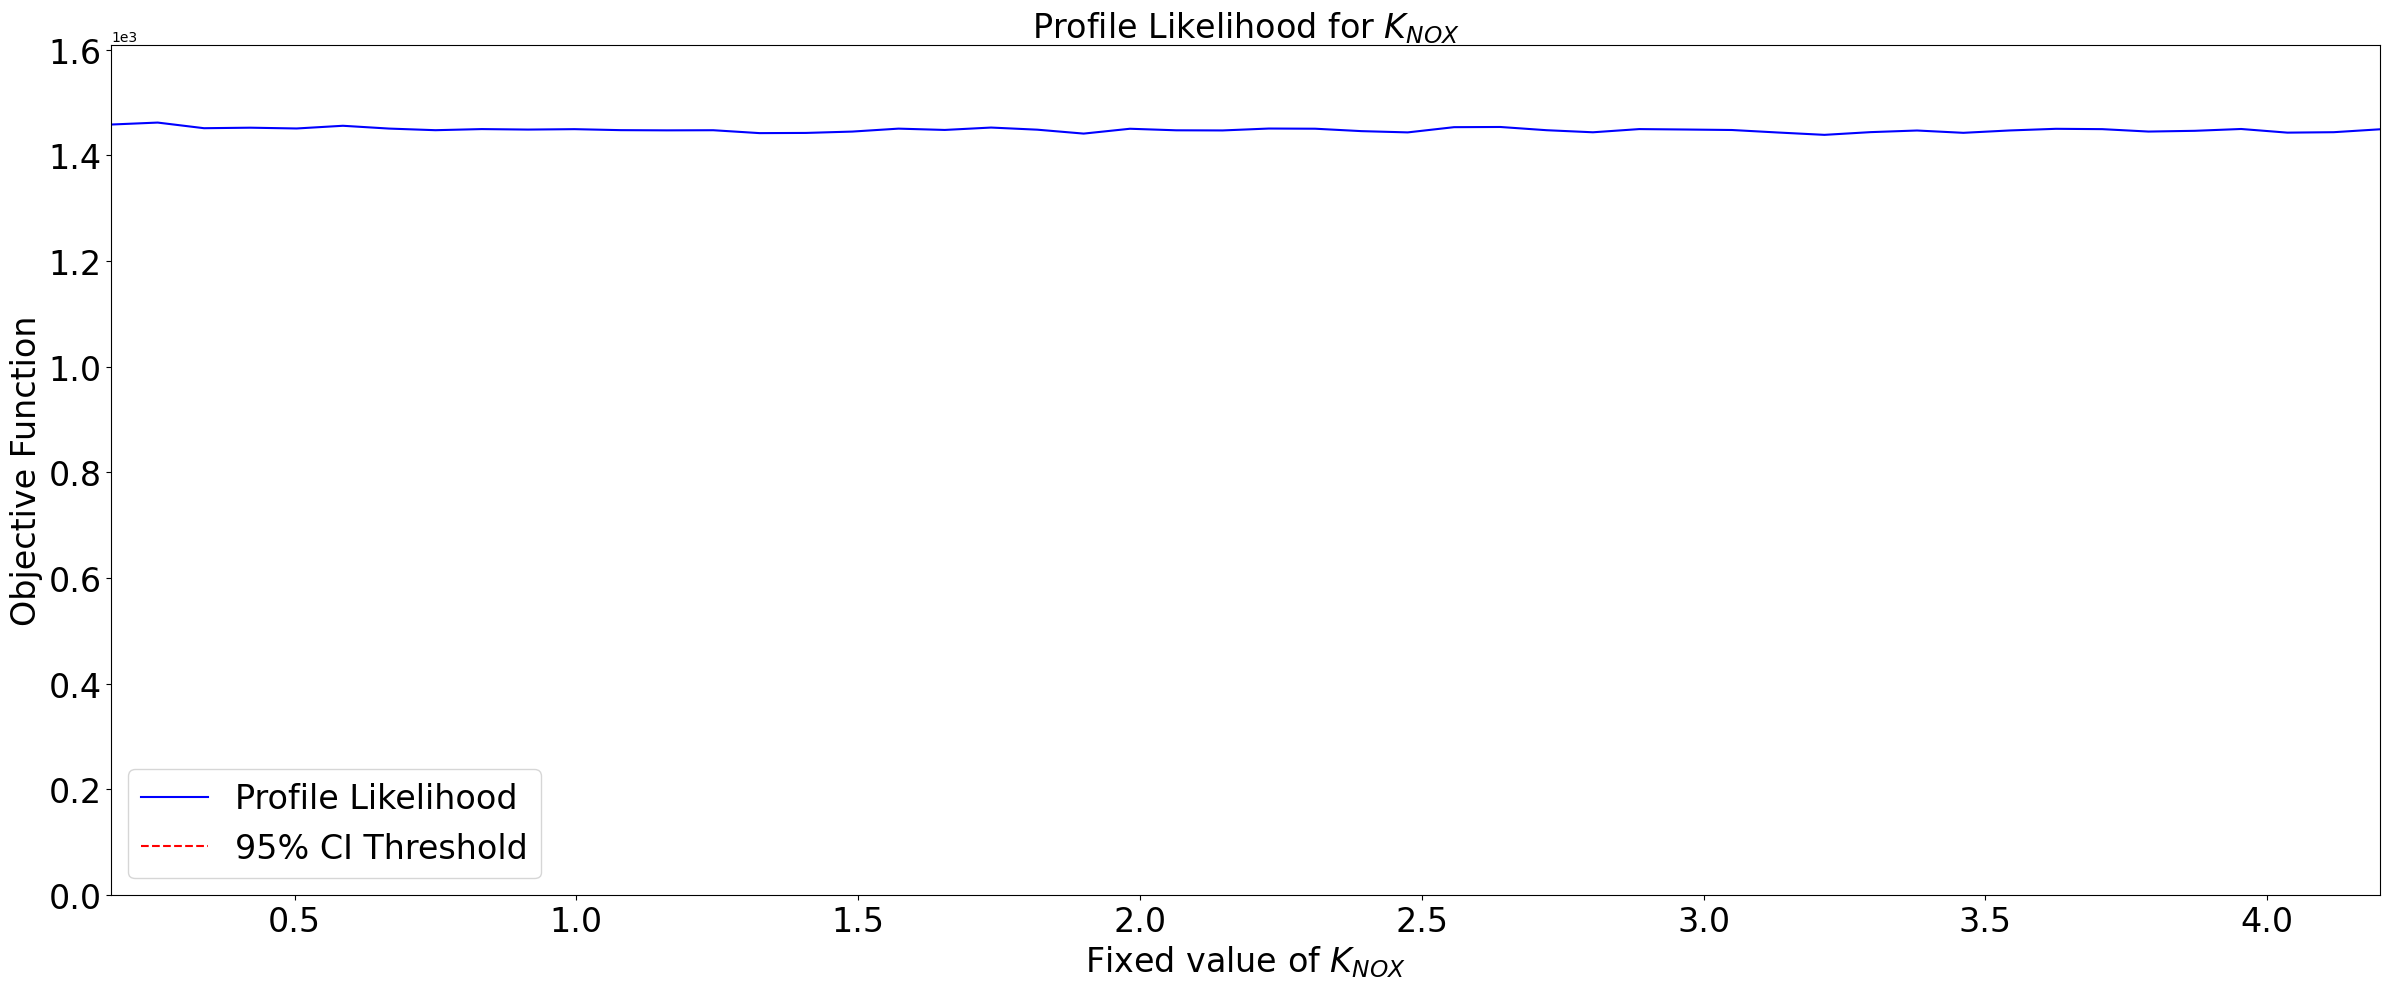

----------------------------------
Profile Likelihood for K_S
----------------------------------


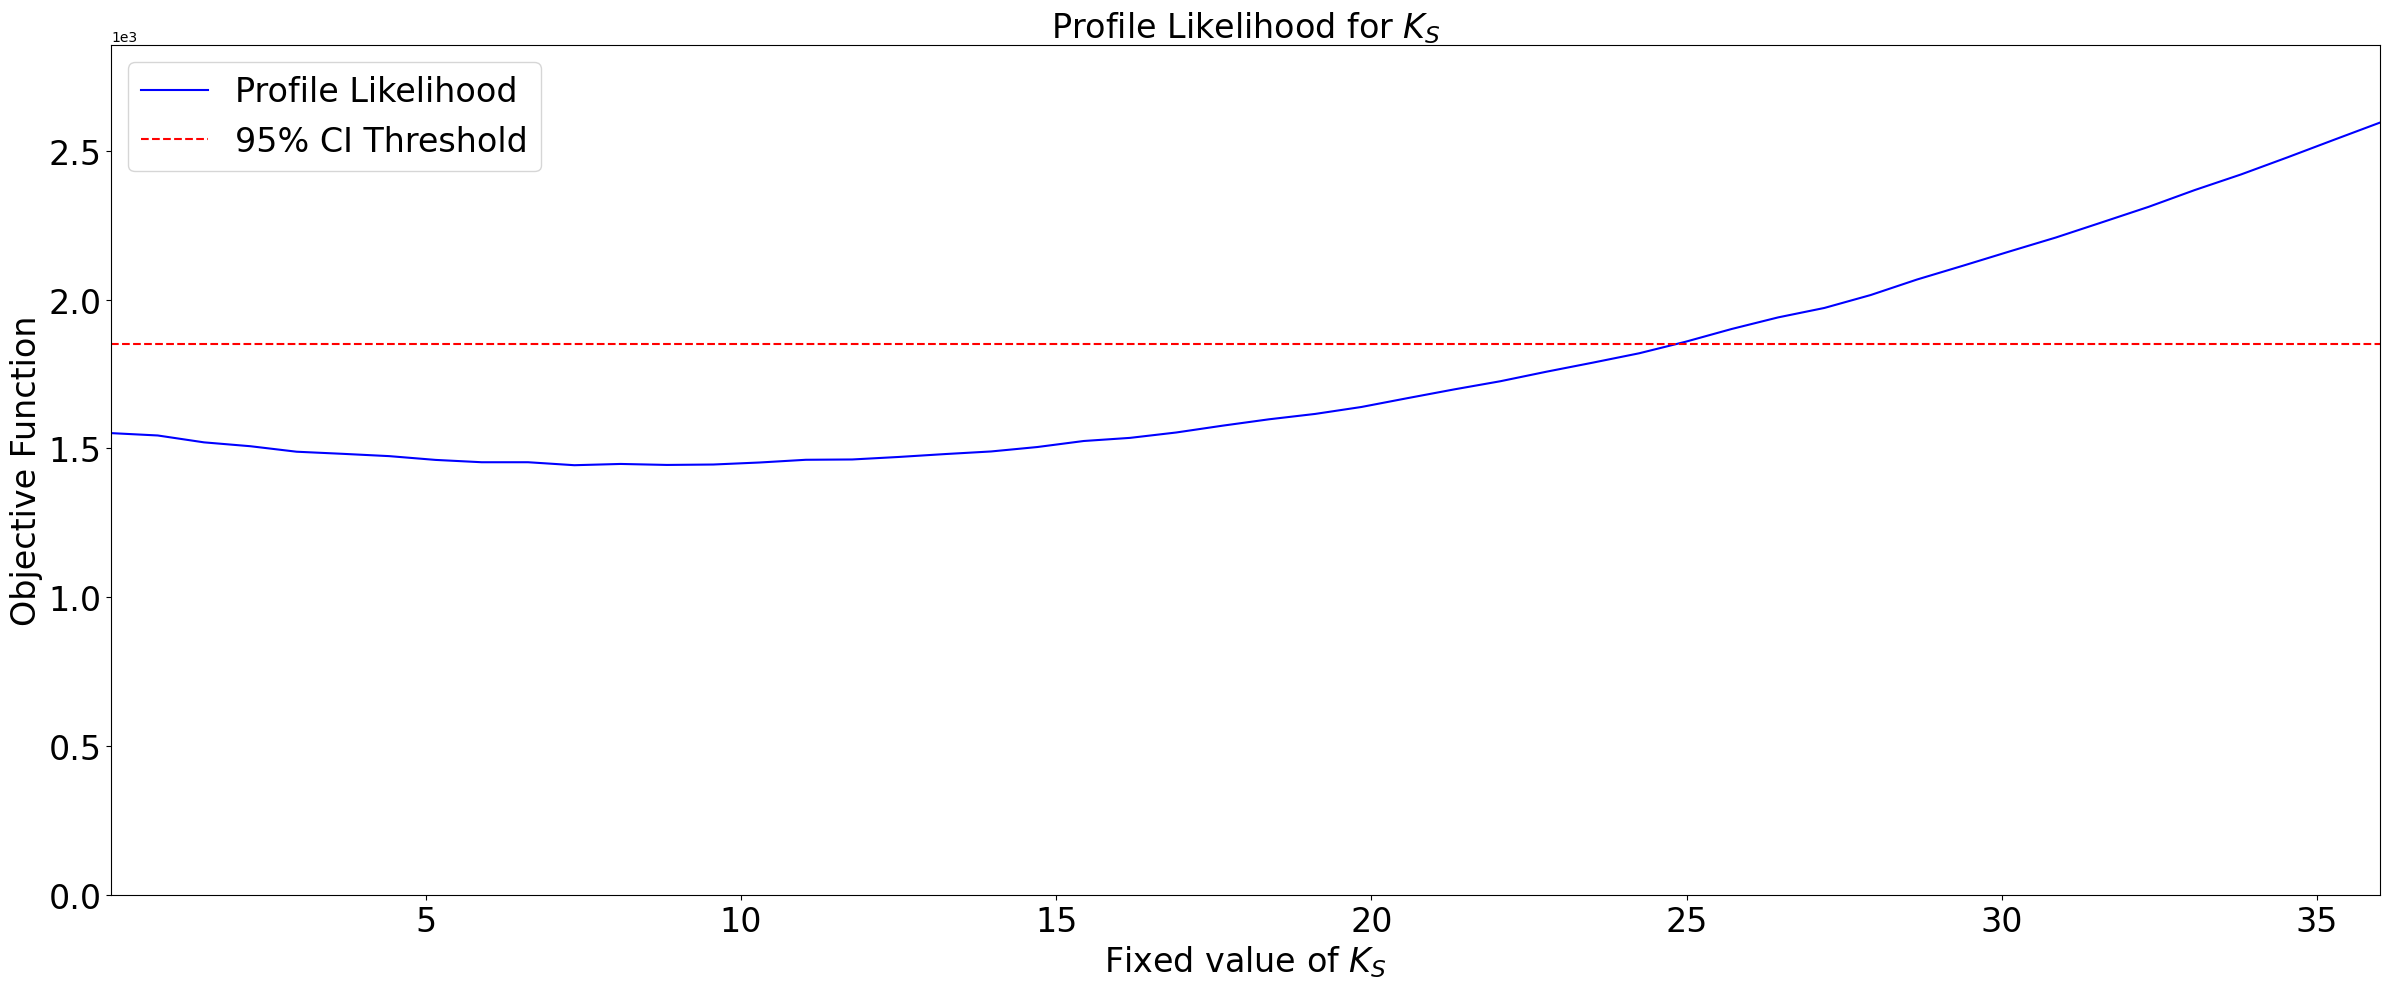

K_STO is always fixed to [0.1], skipping profile likelihood plot.
----------------------------------
Profile Likelihood for mu_H
----------------------------------


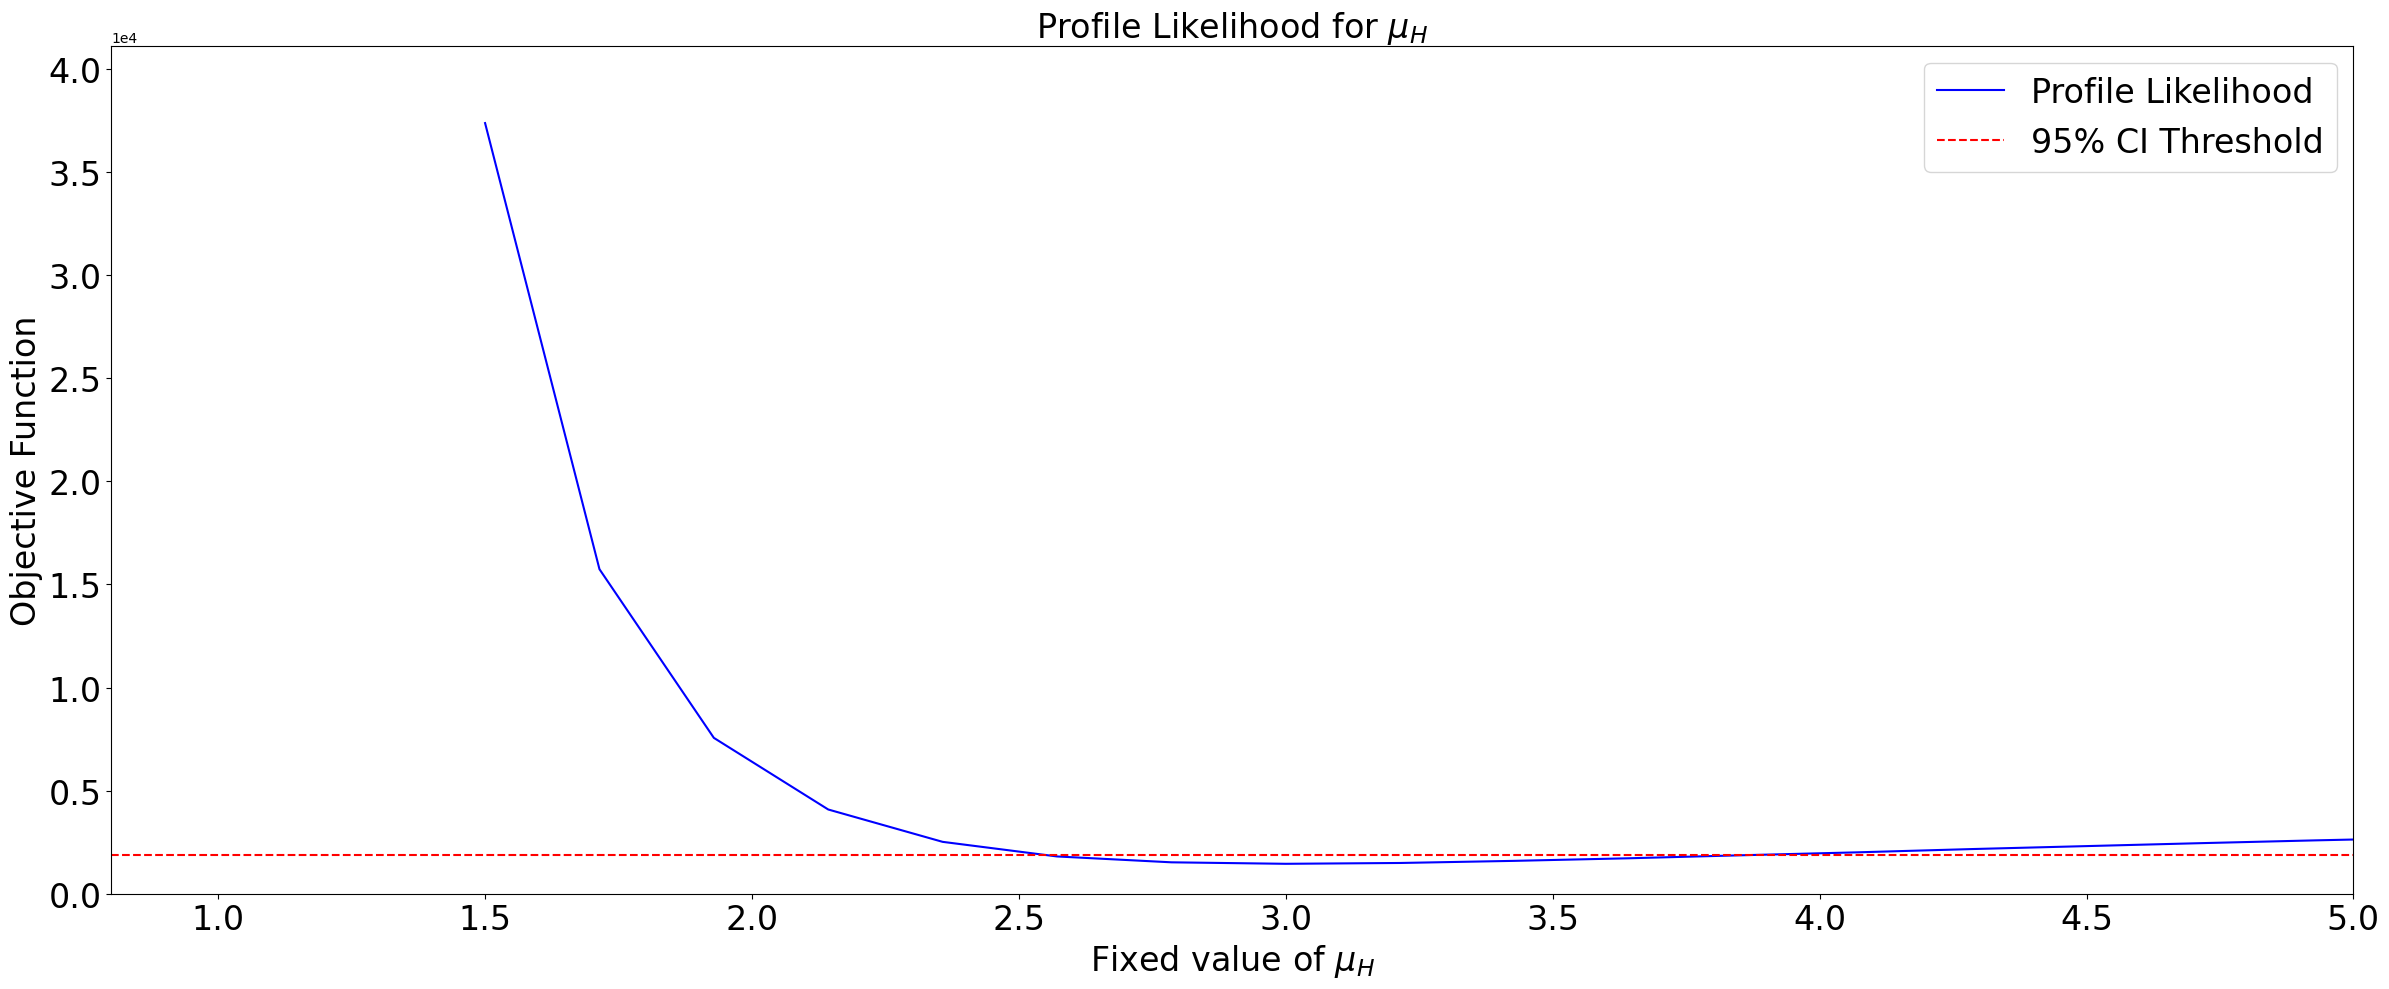

K_NH4 is always fixed to [0.01], skipping profile likelihood plot.
K_ALK is always fixed to [0.1], skipping profile likelihood plot.
b_H_O2 is always fixed to [0.3], skipping profile likelihood plot.
b_H_NOX is always fixed to [0.15], skipping profile likelihood plot.
b_STO_O2 is always fixed to [0.3], skipping profile likelihood plot.
b_STO_NOX is always fixed to [0.15], skipping profile likelihood plot.
----------------------------------
Profile Likelihood for mu_A
----------------------------------


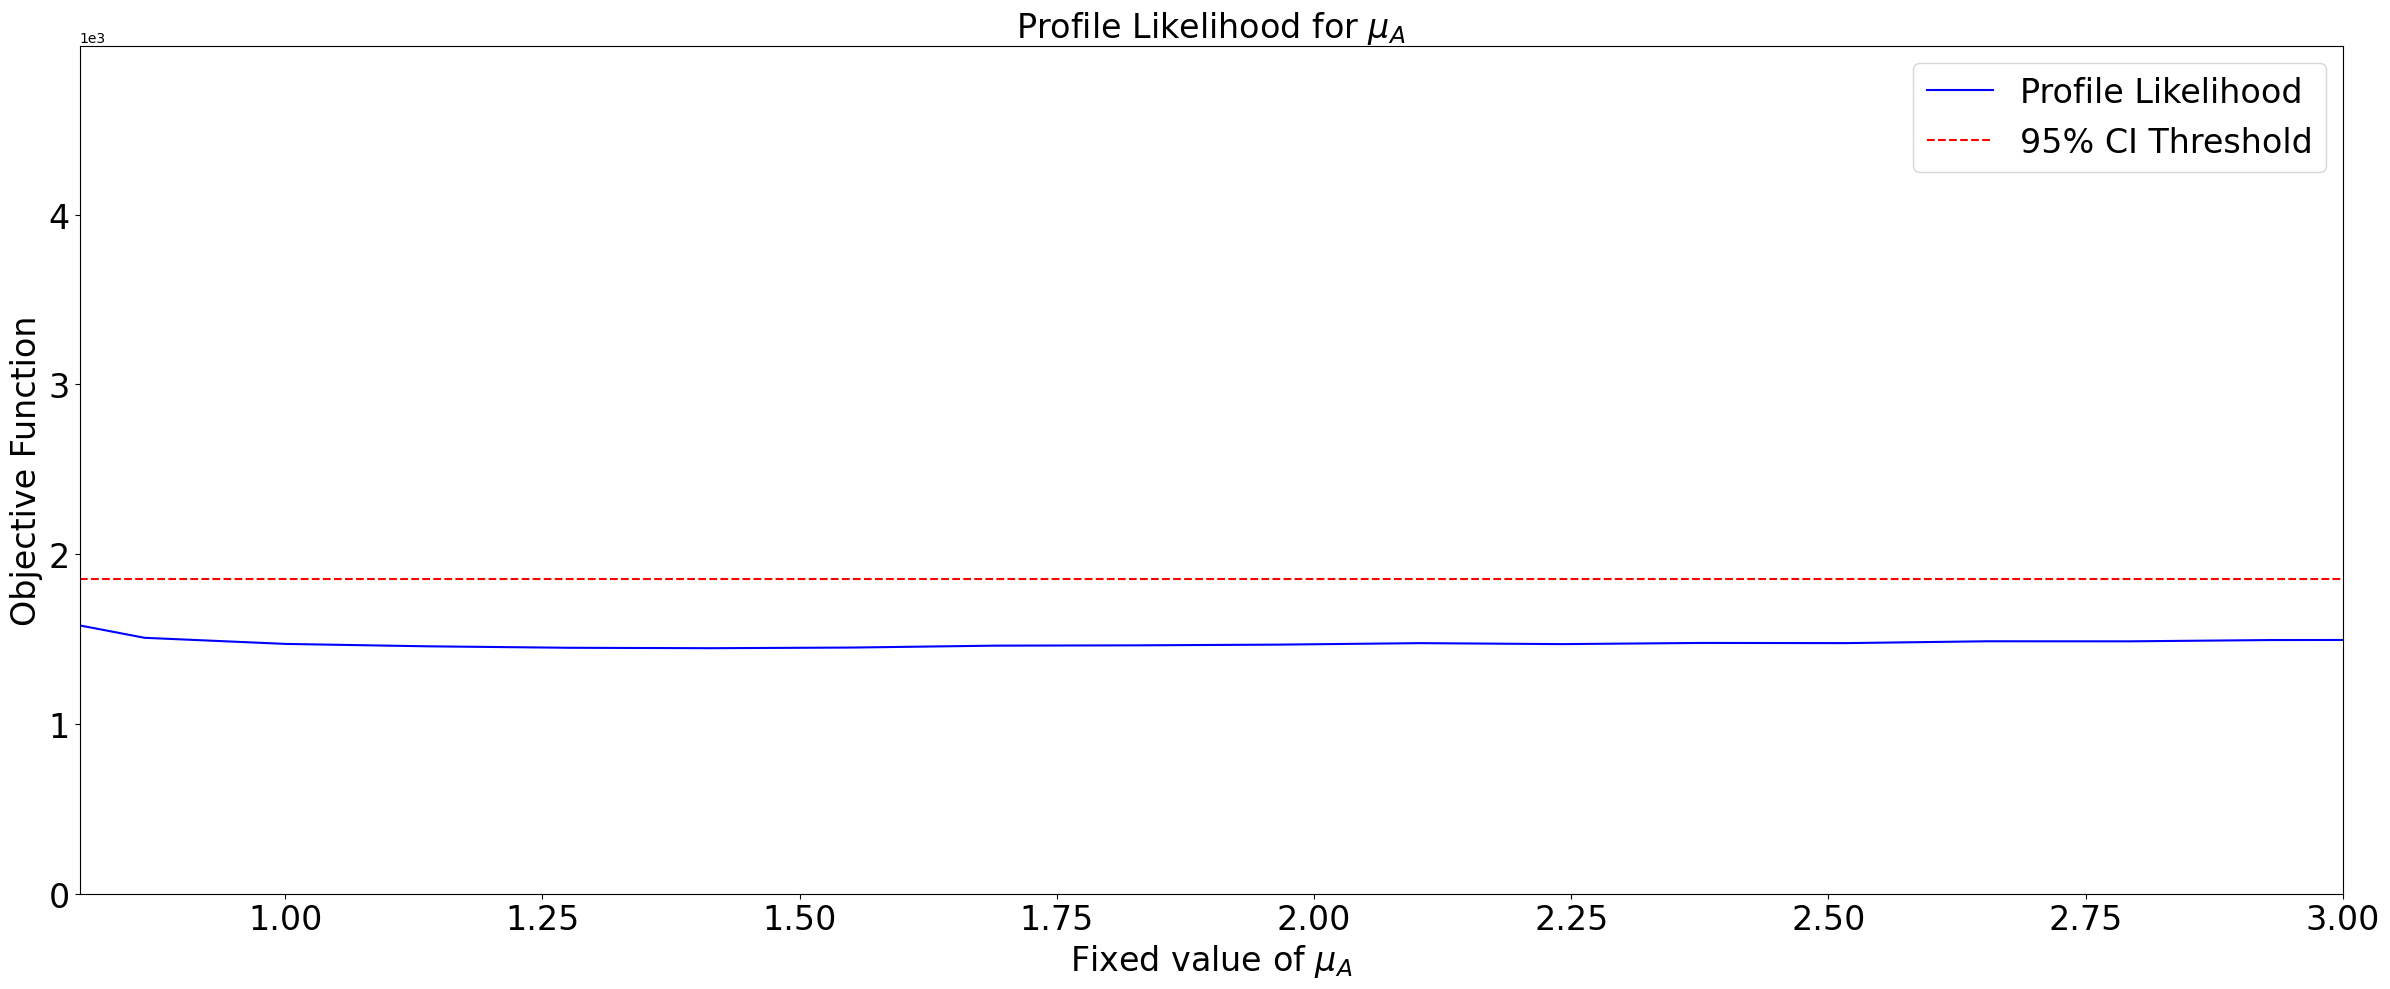

----------------------------------
Profile Likelihood for K_A_NH4
----------------------------------


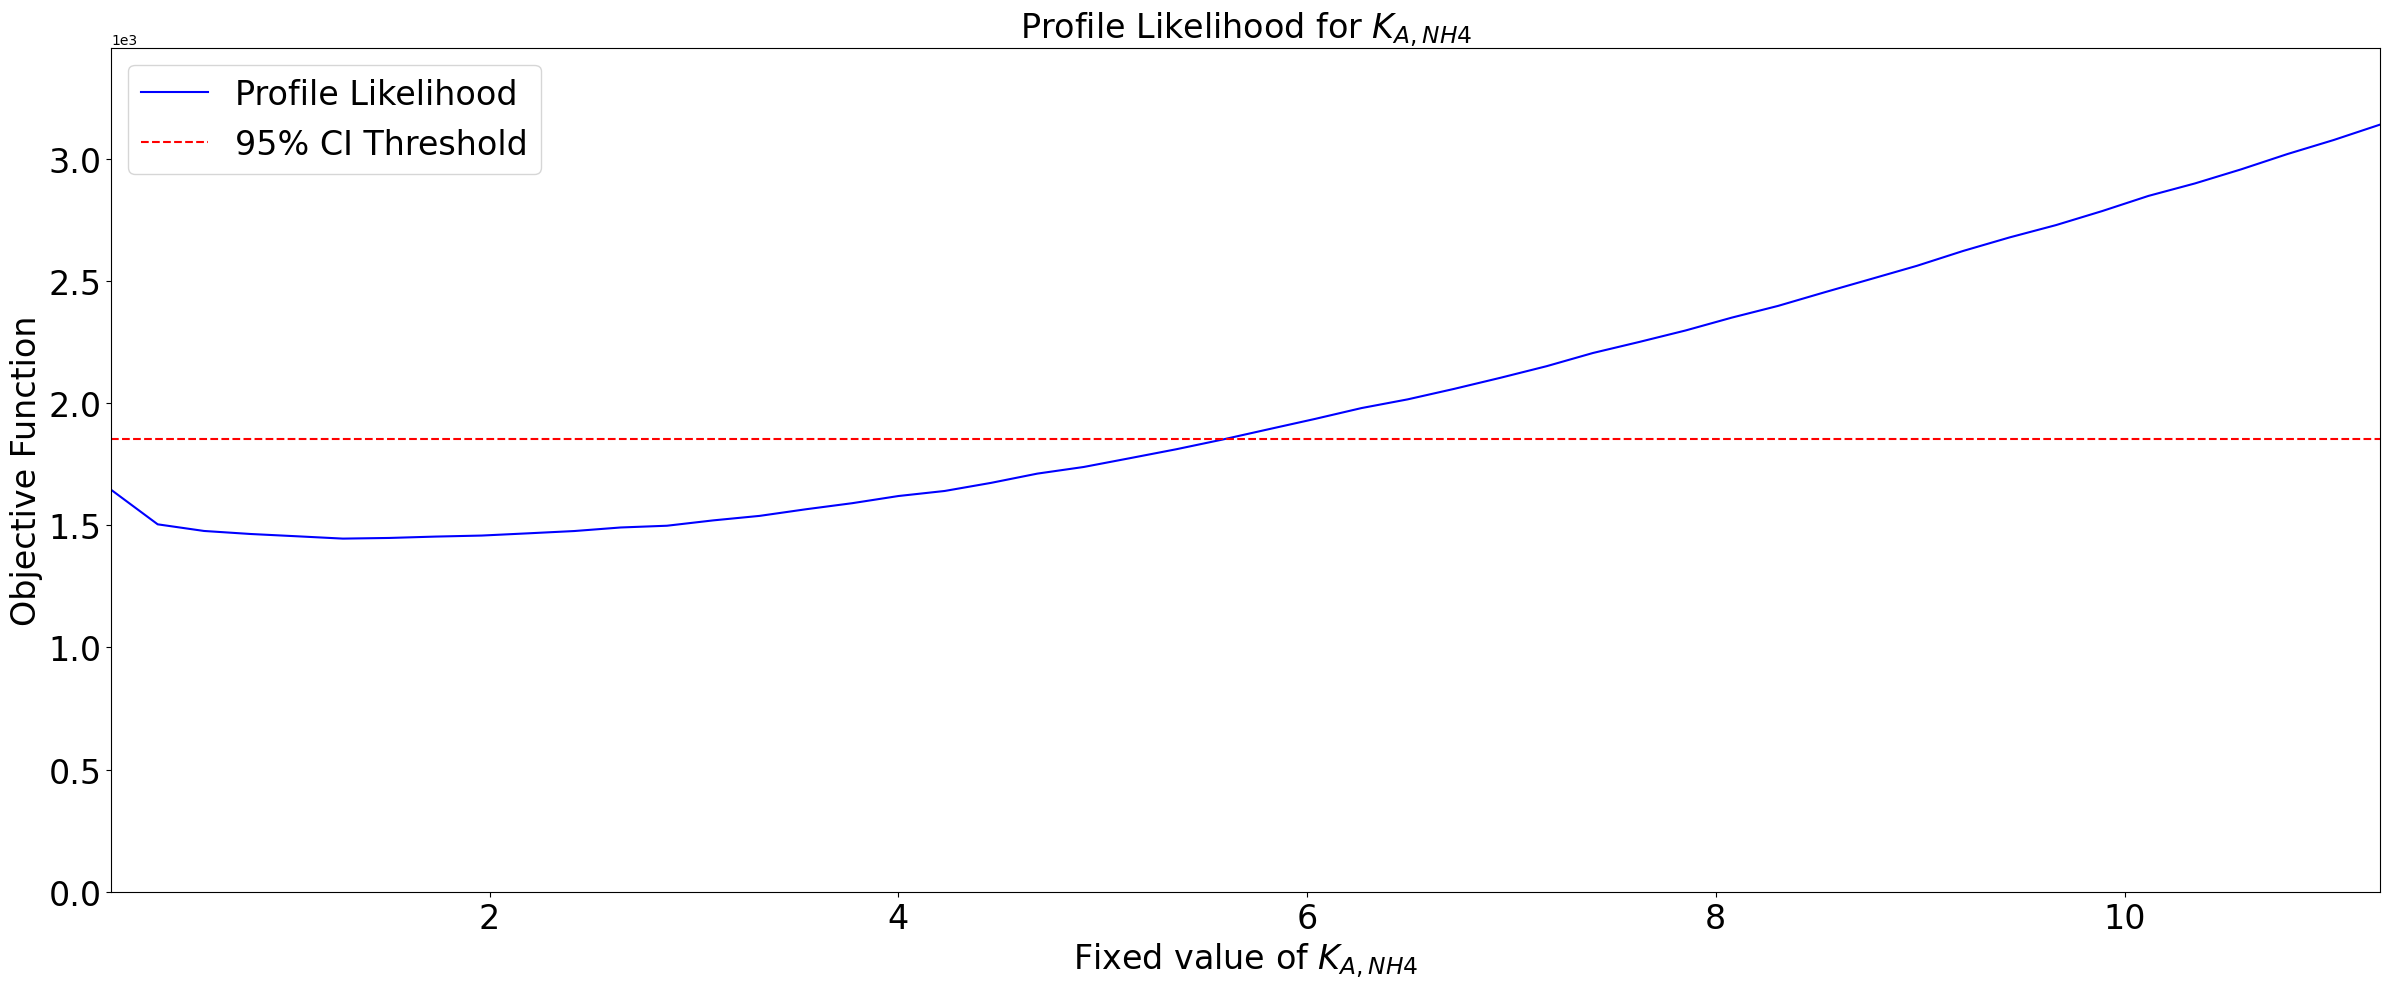

----------------------------------
Profile Likelihood for K_A_O2
----------------------------------


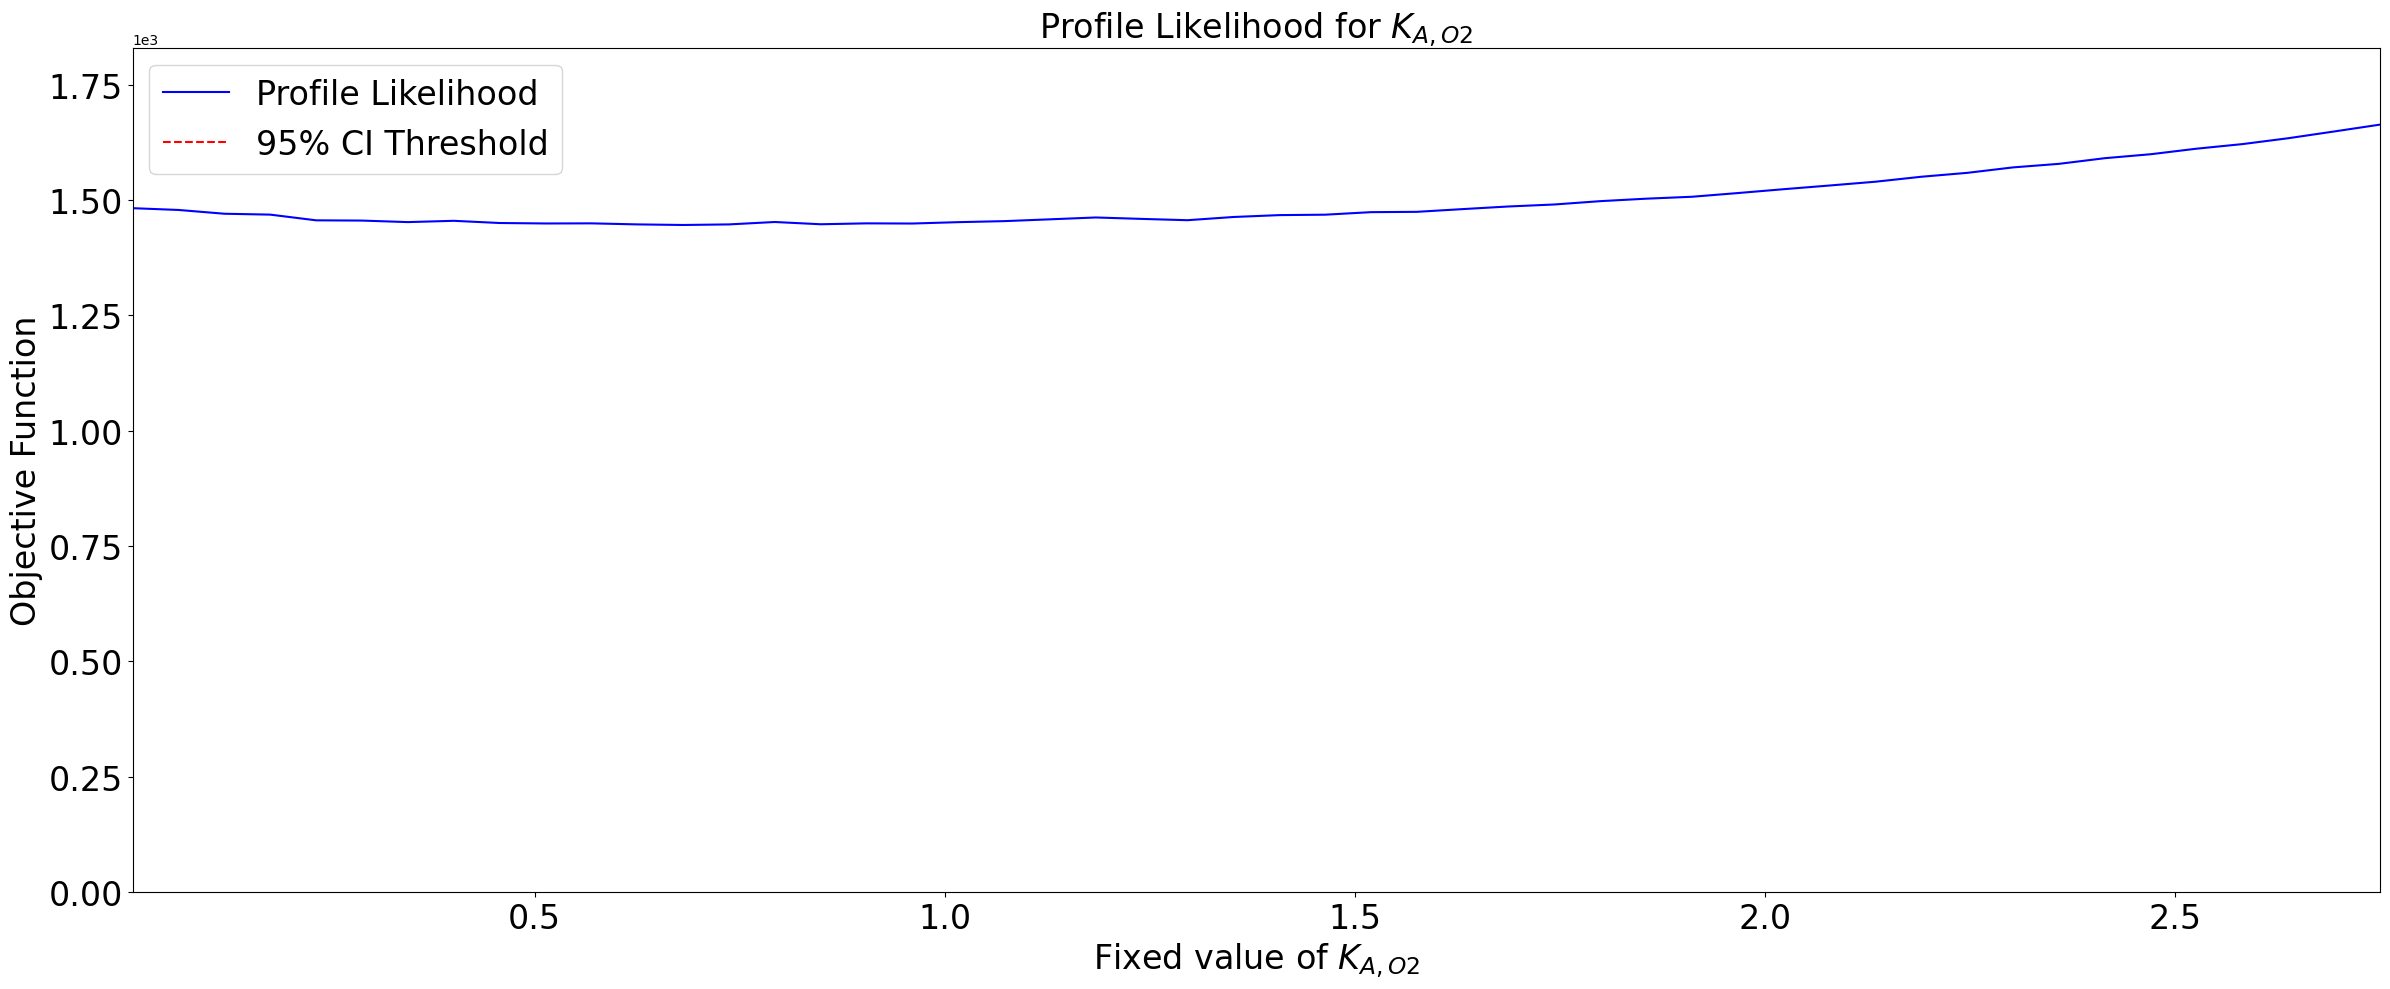

----------------------------------
Profile Likelihood for K_A_ALK
----------------------------------


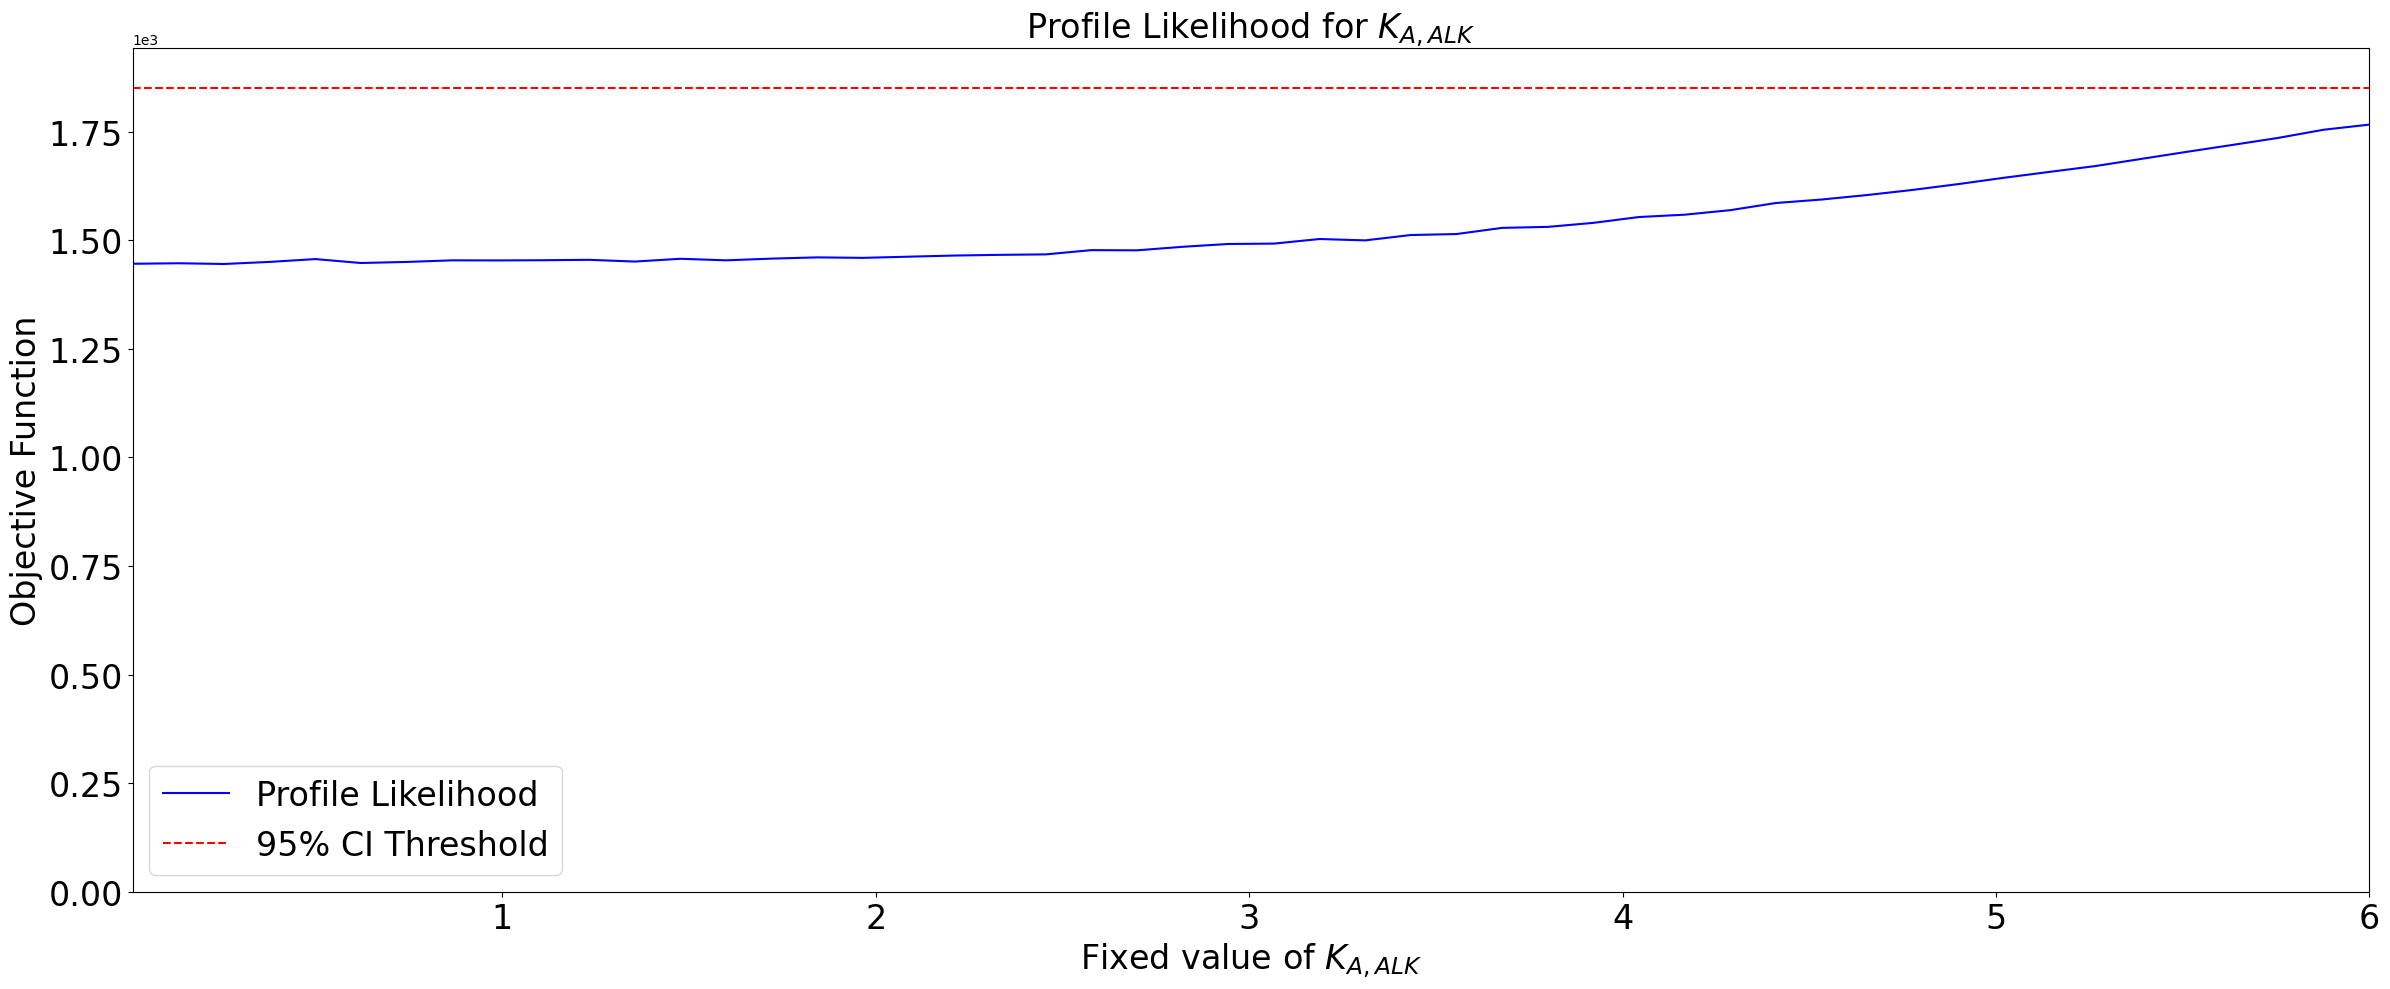

b_A_O2 is always fixed to [0.2], skipping profile likelihood plot.
b_A_NOX is always fixed to [0.1], skipping profile likelihood plot.
f_S_I is always fixed to [1e-06], skipping profile likelihood plot.
----------------------------------
Profile Likelihood for Y_STO_O2
----------------------------------


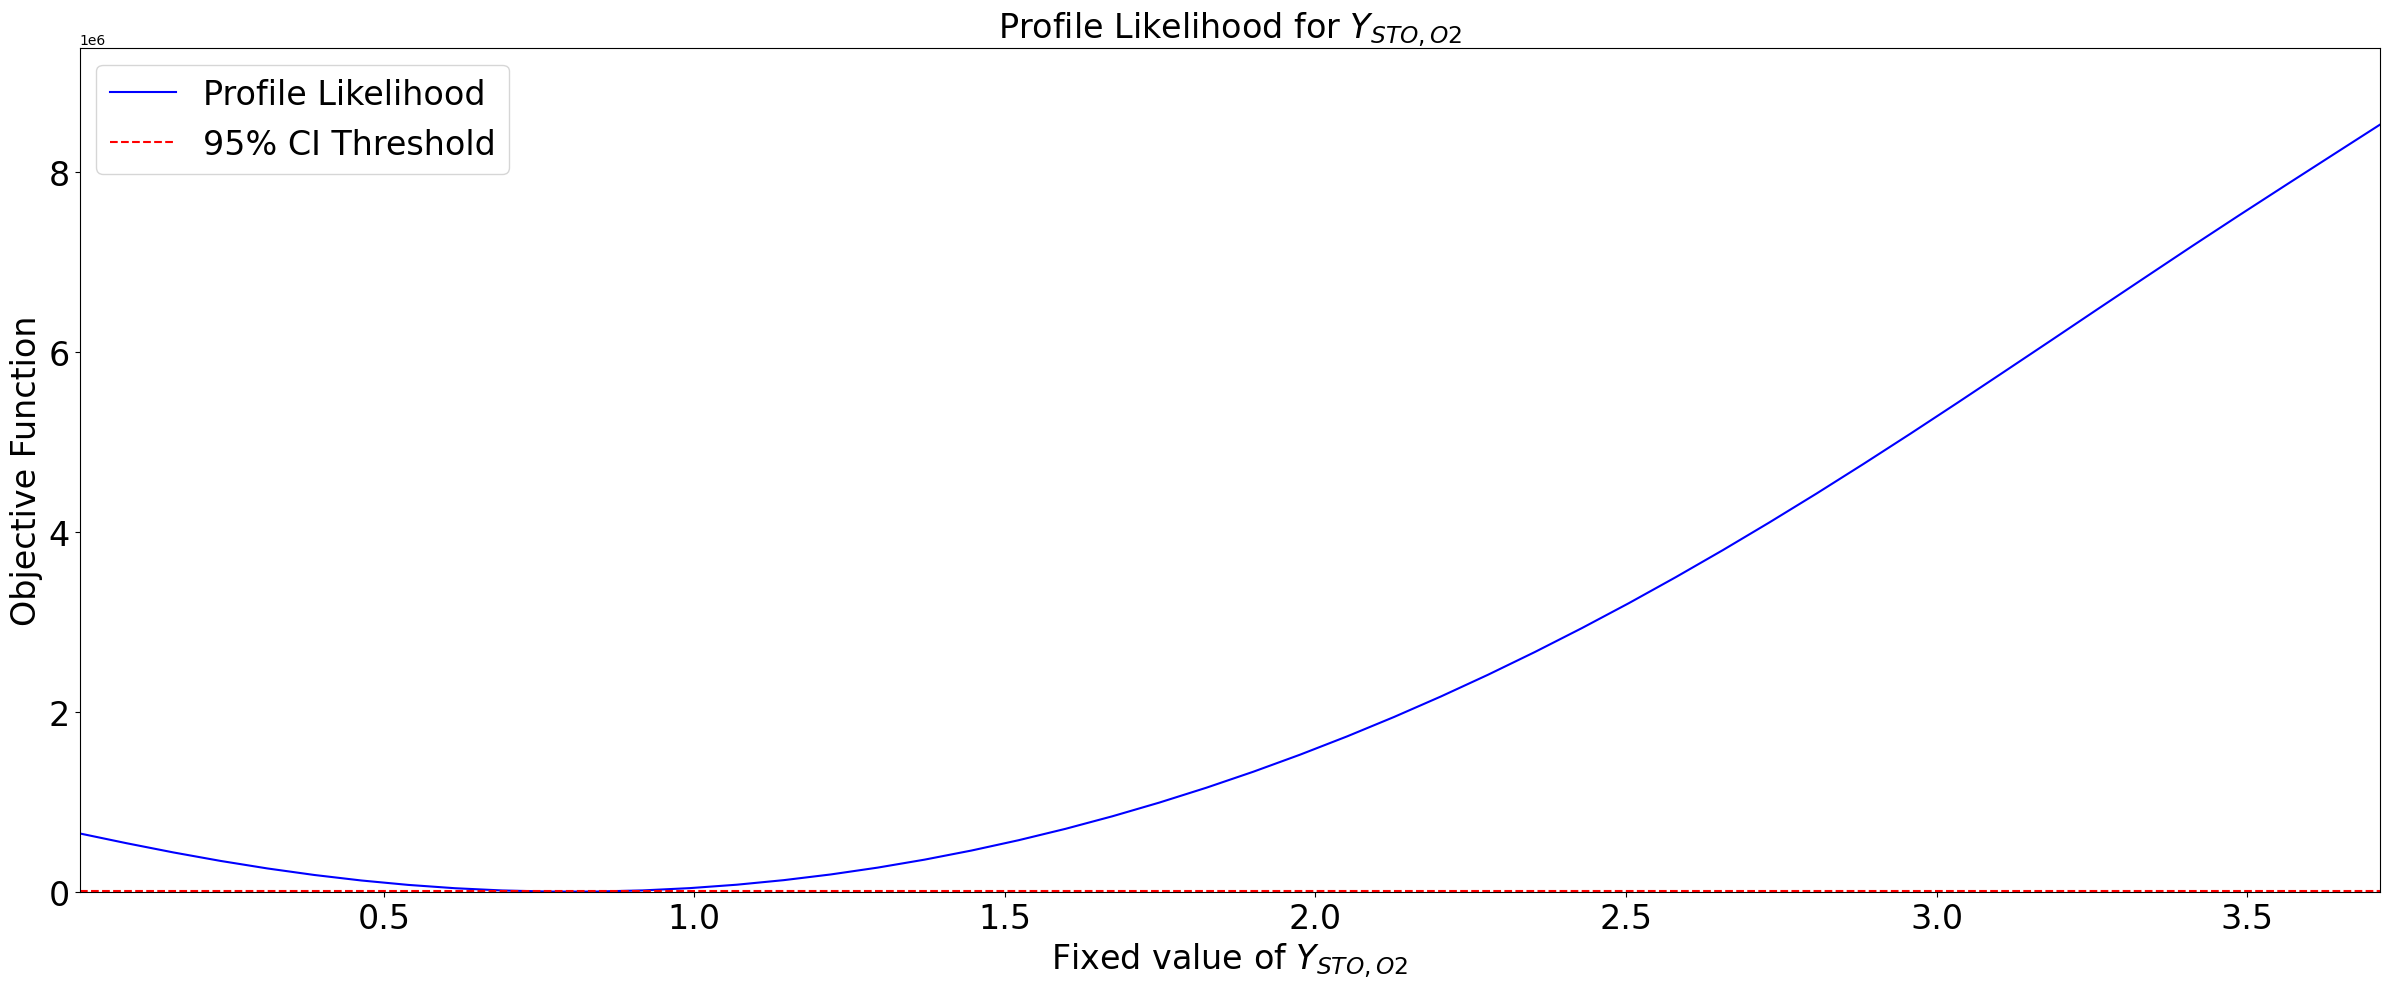

----------------------------------
Profile Likelihood for Y_STO_NOX
----------------------------------


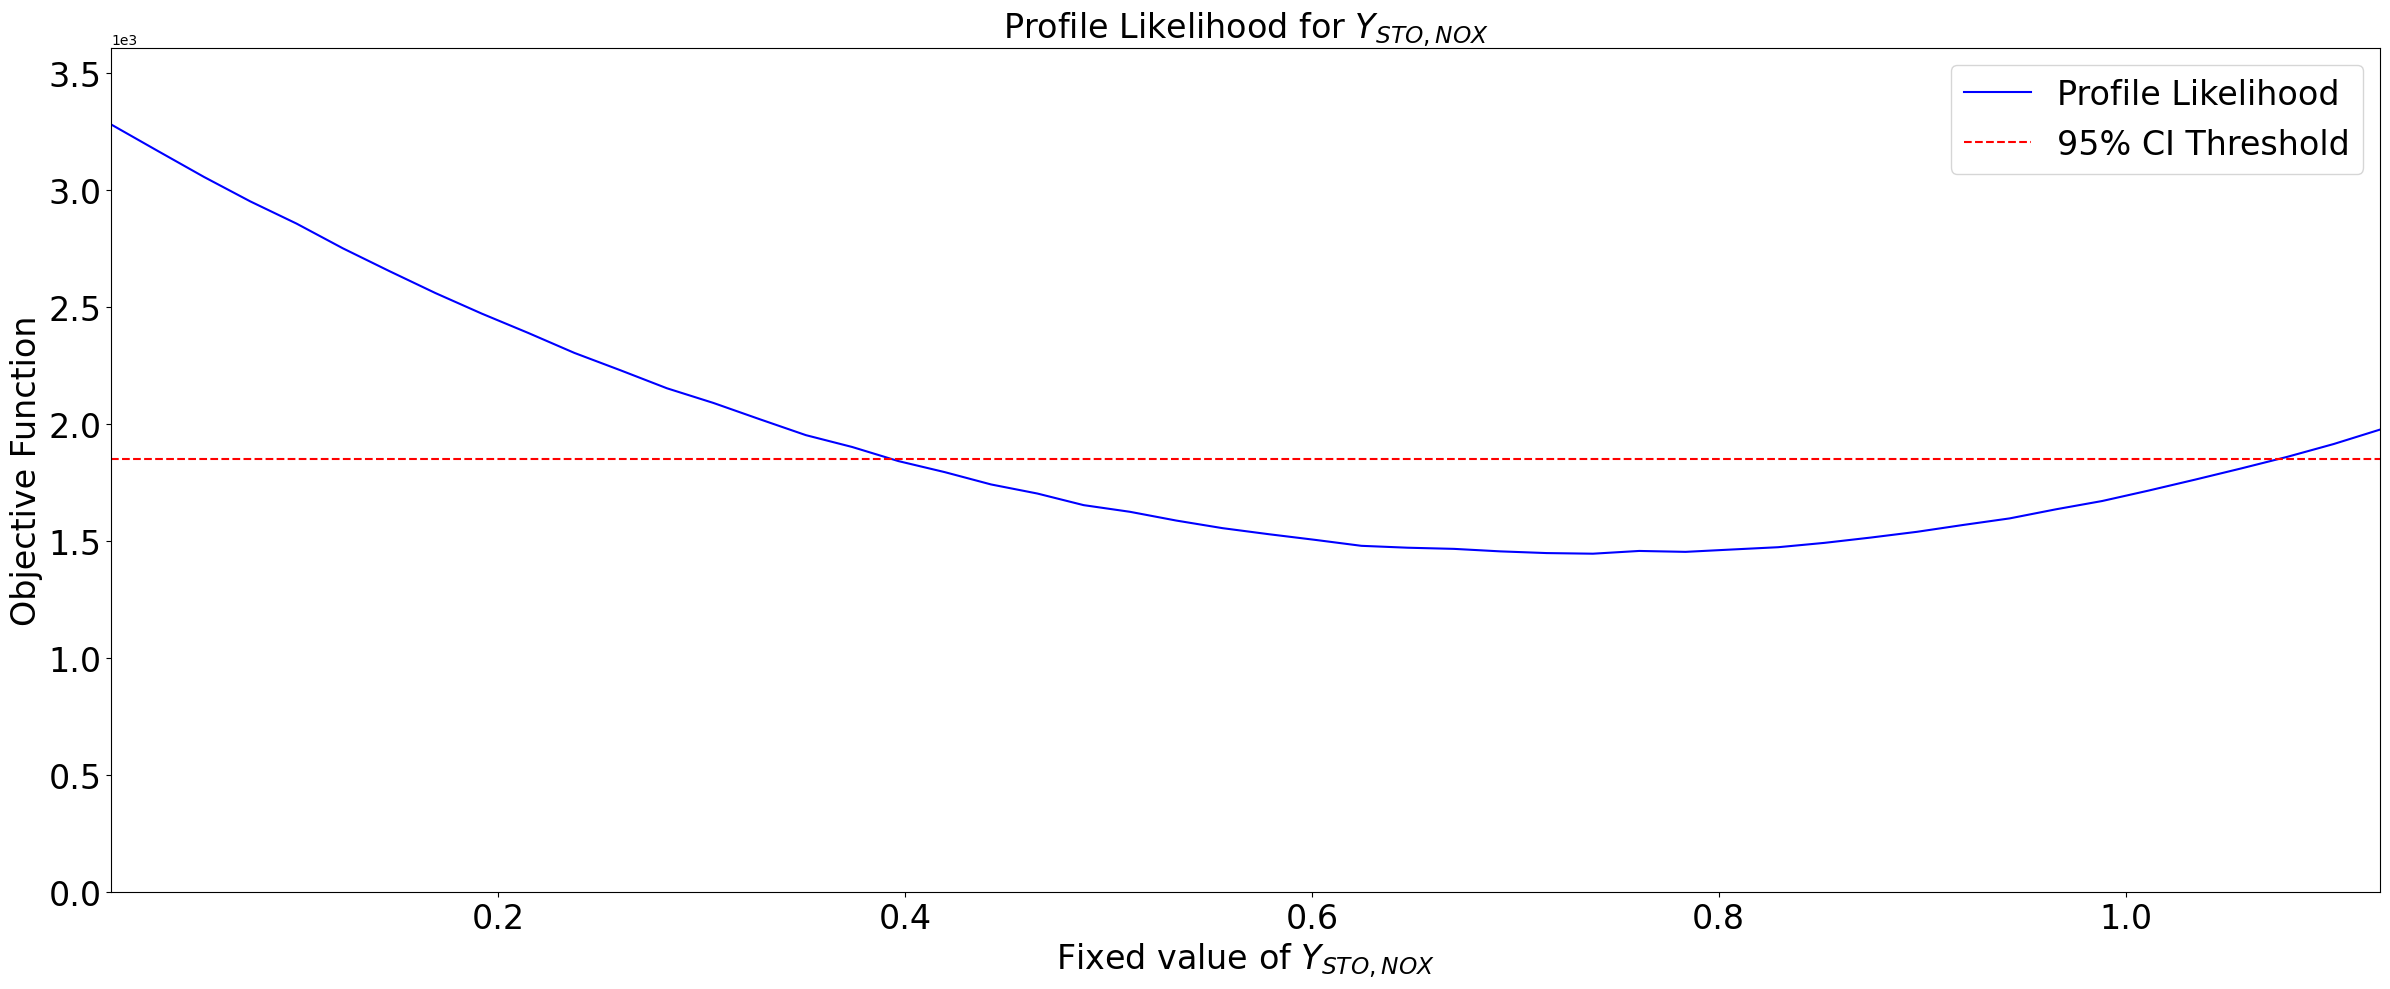

----------------------------------
Profile Likelihood for Y_H_O2
----------------------------------


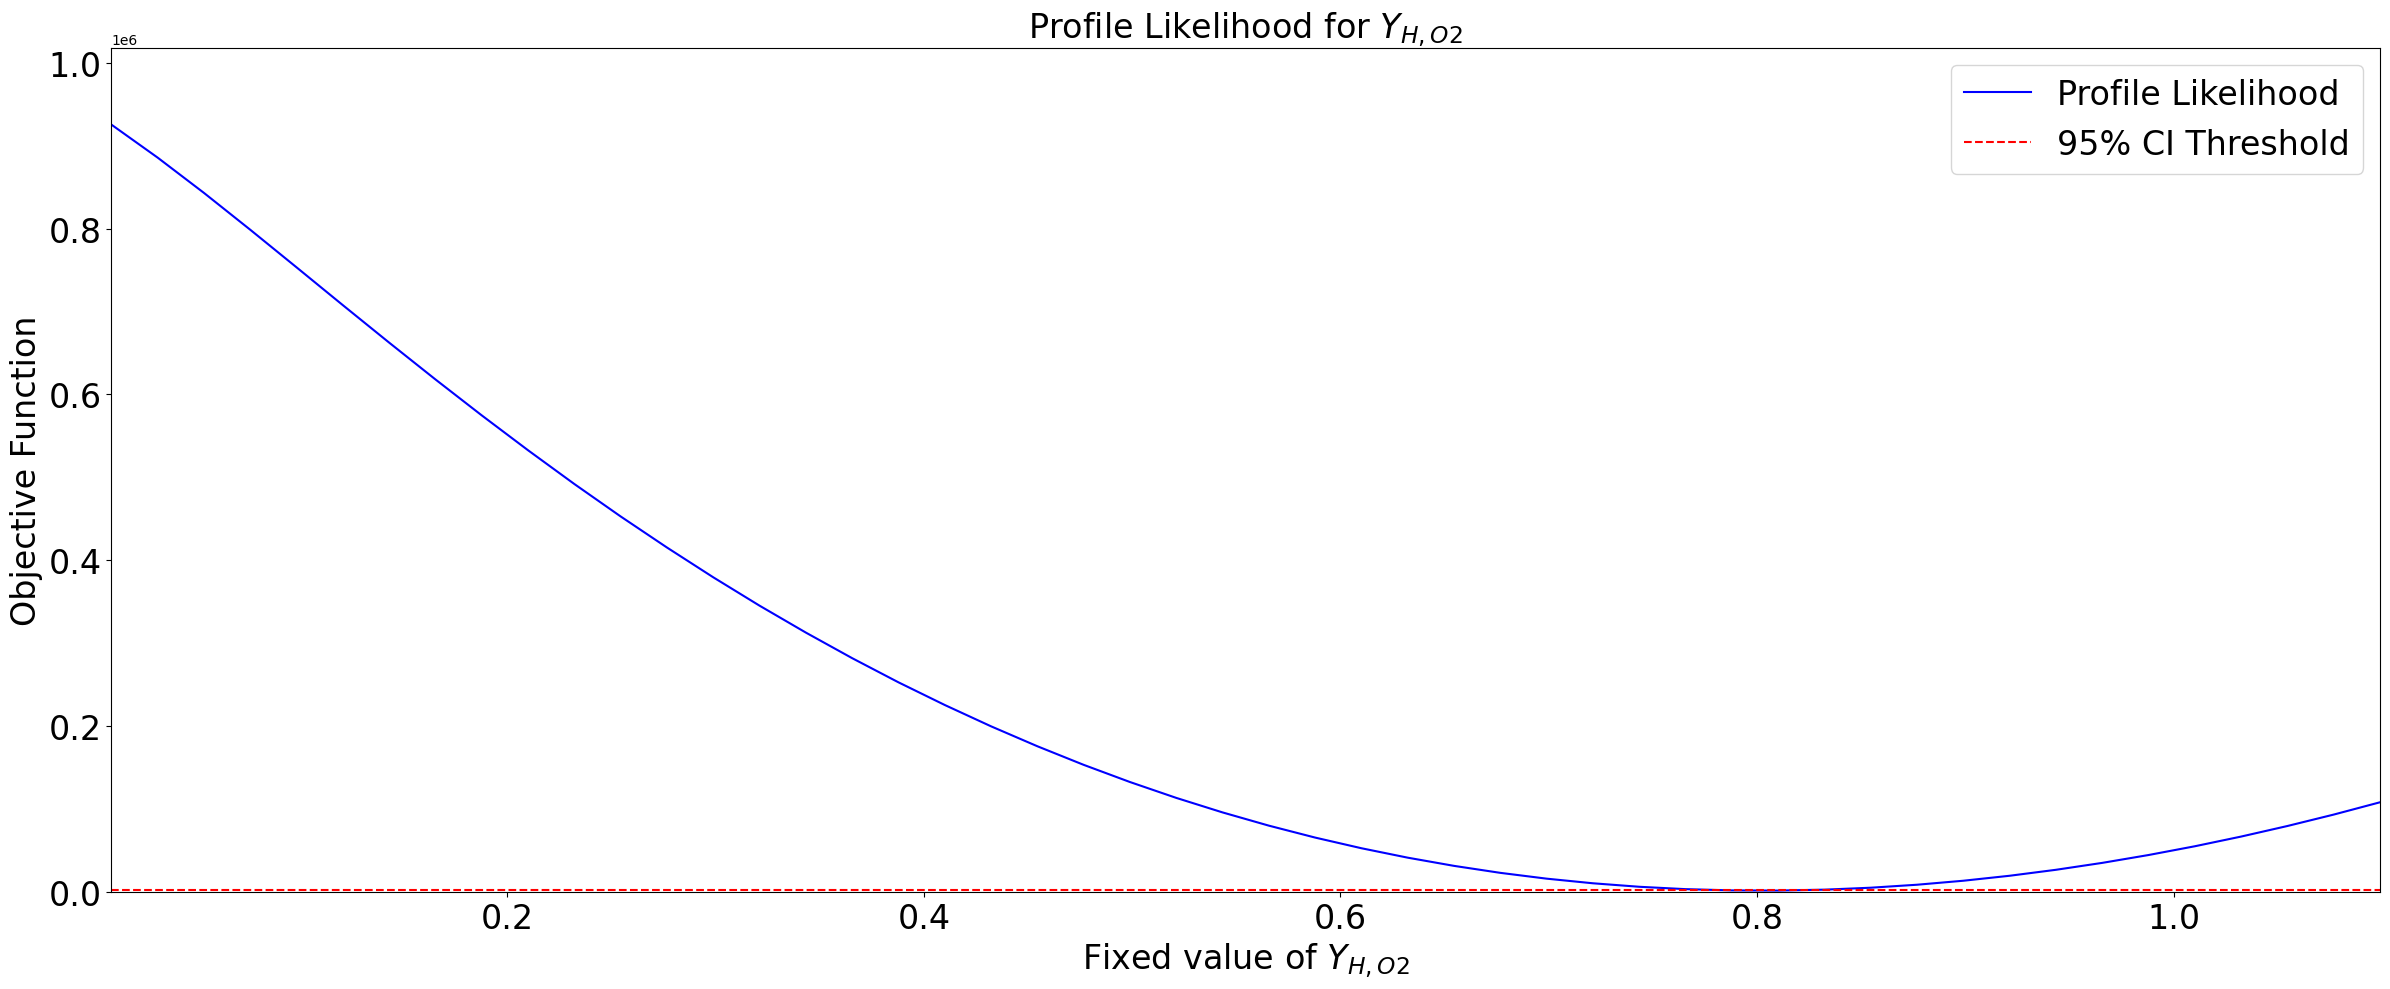

----------------------------------
Profile Likelihood for Y_H_NOX
----------------------------------


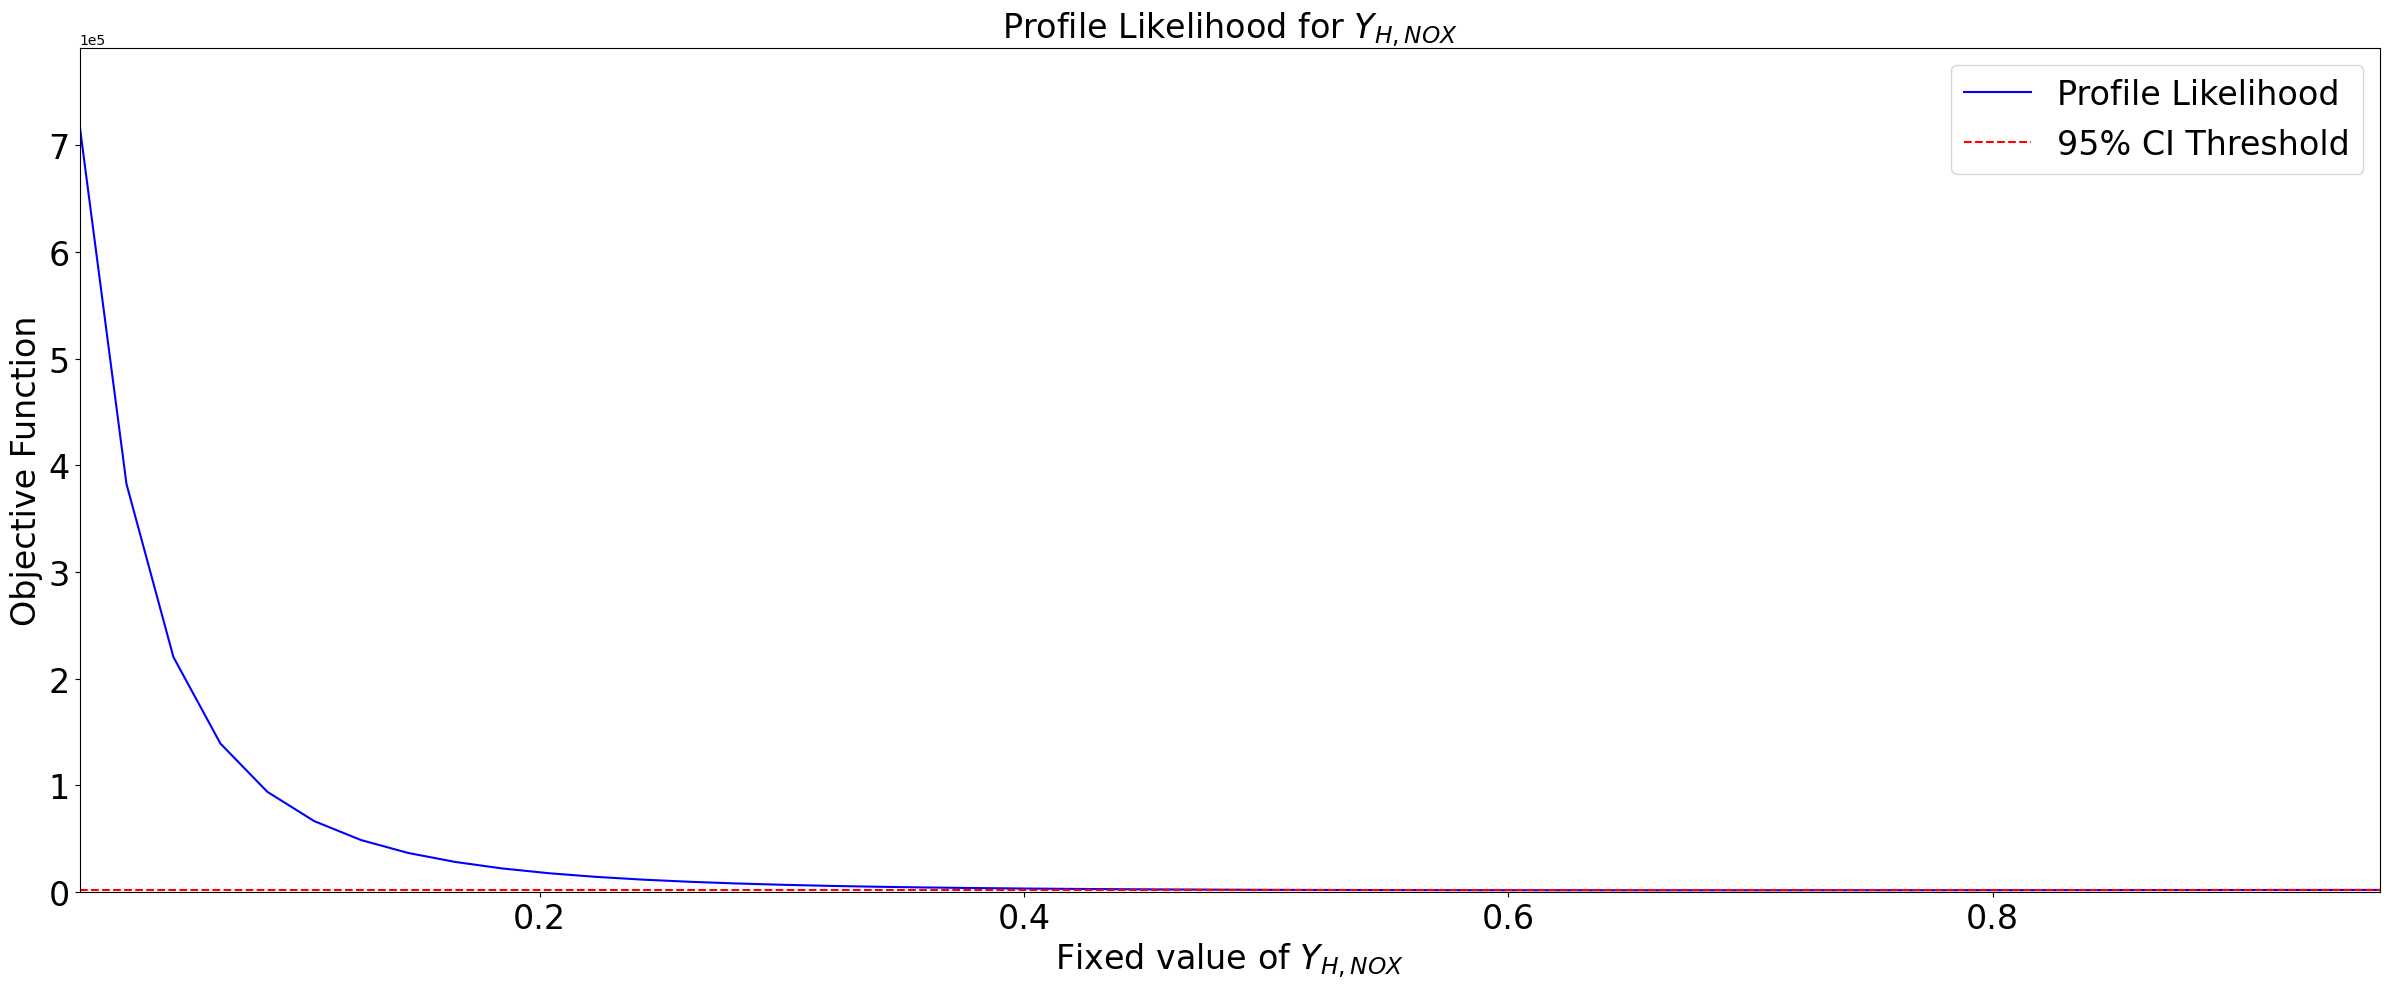

----------------------------------
Profile Likelihood for Y_A
----------------------------------


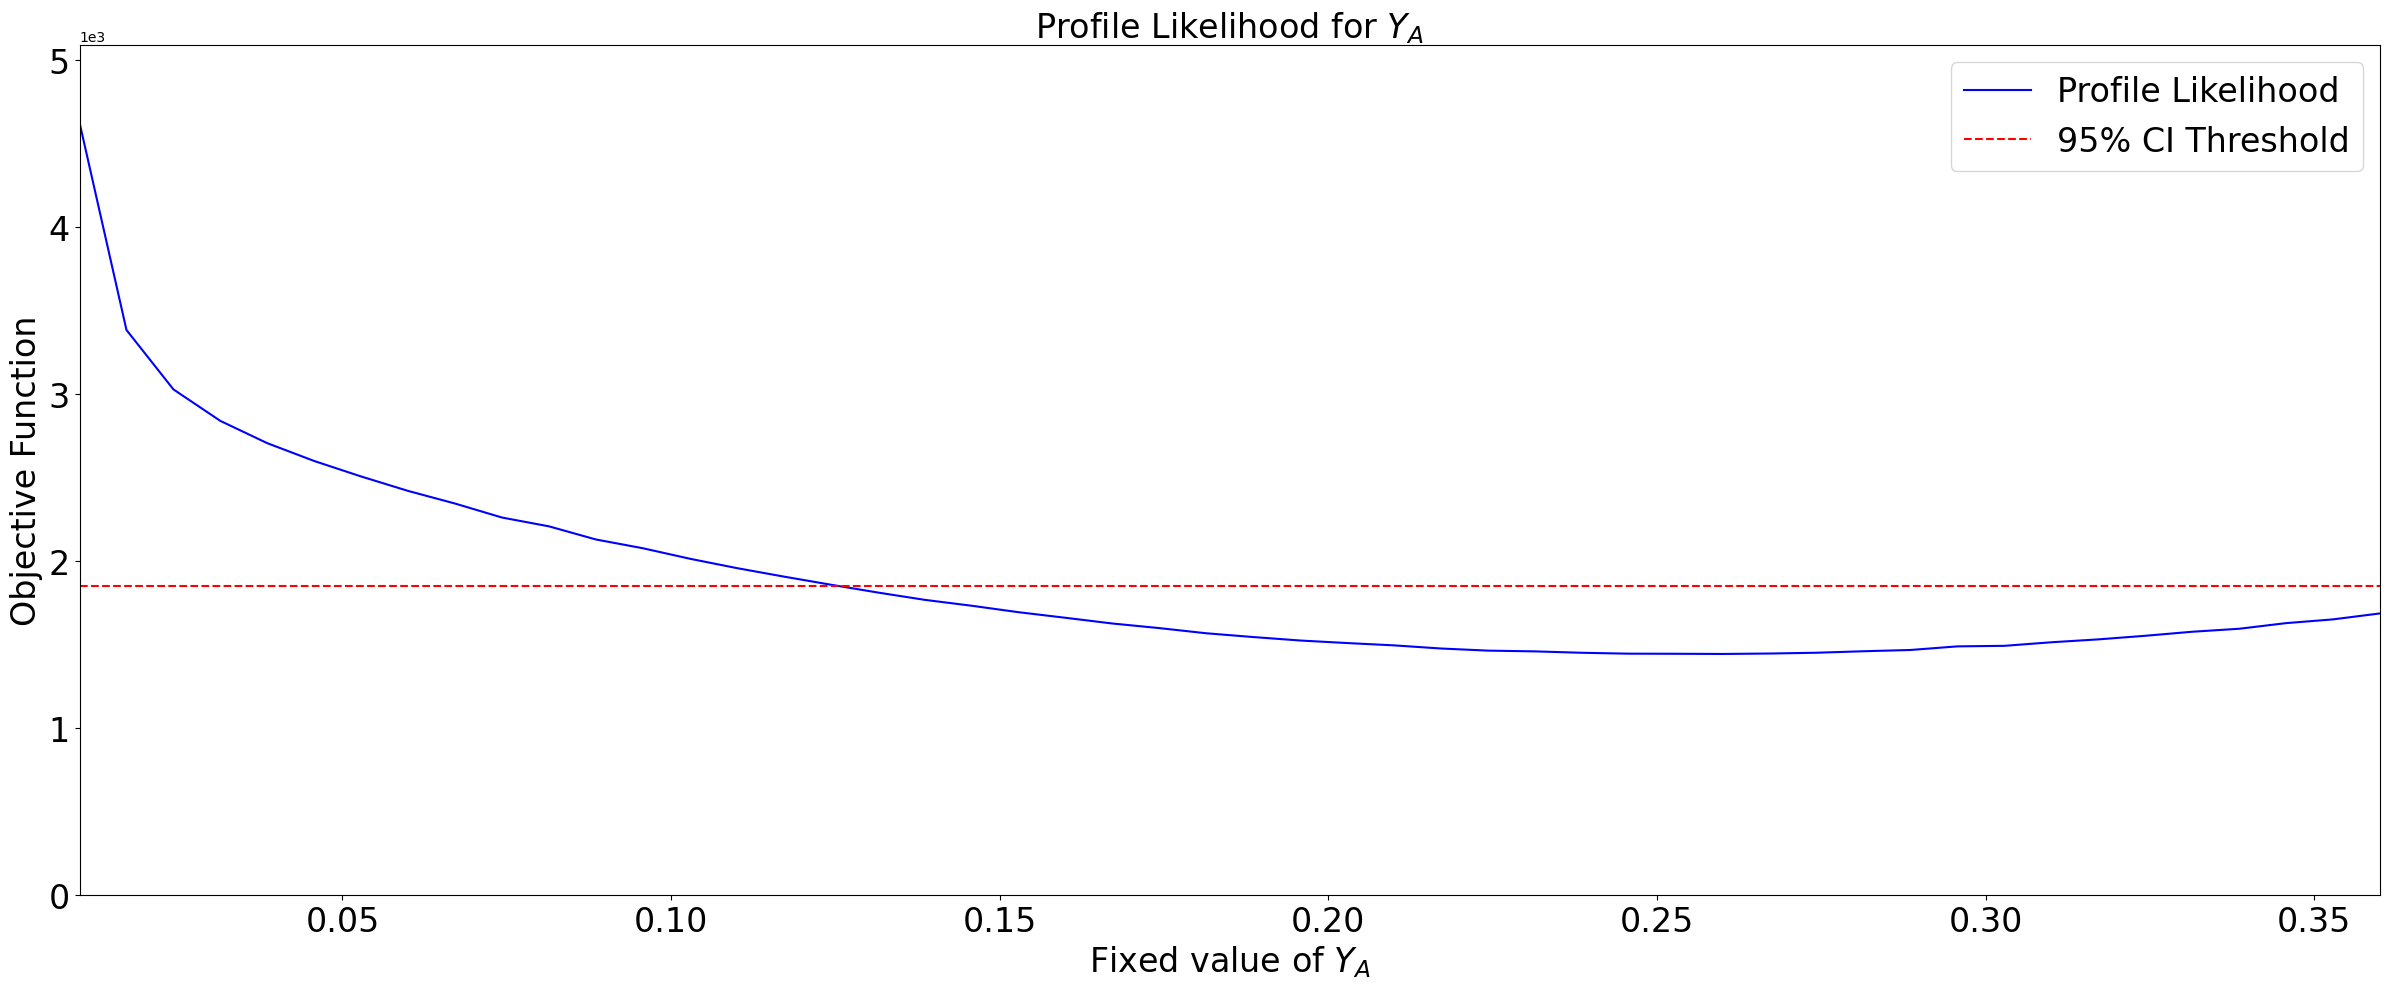

f_X_I is always fixed to [0.2], skipping profile likelihood plot.
i_N_S_I is always fixed to [0.01], skipping profile likelihood plot.
i_N_S_S is always fixed to [0.03], skipping profile likelihood plot.
i_N_X_I is always fixed to [0.04], skipping profile likelihood plot.
i_N_X_S is always fixed to [0.03], skipping profile likelihood plot.
i_N_BM is always fixed to [0.07], skipping profile likelihood plot.
i_SS_X_I is always fixed to [0.75], skipping profile likelihood plot.
i_SS_X_S is always fixed to [0.75], skipping profile likelihood plot.
i_SS_BM is always fixed to [0.9], skipping profile likelihood plot.


In [4]:
# ----------------------------------------------------------
## Plot profile likelihood results from Identifiability Results
# ----------------------------------------------------------

# Create dictionaries for results
CI_threshold = {}
fixed_values = {}
obj_vals = {}
theta_vals = {}

# Manual axis limits
specific_X_lim_plots = {
    'mu_H': (0.8, 5),
    'mu_A': (0.8, 3),
}

specific_Y_lim_plots = {
    # 'mu_H': (0, 50000),
    # 'mu_A': (0, 35000),
    'eta_NOX': (100000, 150000),
}

# Loop through all profile likelihood results
for col in ProfileLikelihoodResults.columns:
    param_name = col.replace("_fix", "")

    # Skip parameters that are always fixed
    if param_name in params_to_always_fix:
        print(f'{param_name} is always fixed to [{params_to_always_fix[param_name]}], skipping profile likelihood plot.')
        continue

    print('----------------------------------')
    print(f'Profile Likelihood for {param_name}')
    print('----------------------------------')

    fixed_values[param_name] = []
    obj_vals[param_name] = []
    theta_vals[param_name] = []

    # Extract values
    for entry in ProfileLikelihoodResults[col]:
        fixed_val = entry['theta'][all_param_idx[param_name]]
        obj_val_entry = entry['obj_val']
        fixed_values[param_name].append(fixed_val)
        obj_vals[param_name].append(obj_val_entry)
        theta_vals[param_name].append(entry['theta'])

    # Compute CI threshold
    CI_min_sse = np.min(obj_vals[param_name])
    CI_n = len(Data_Effluent['Time'])
    CI_p = num_params
    CI_alpha = 0.05
    CI_f_value = f_dist.ppf(1 - CI_alpha, 1, CI_n - CI_p)
    CI_threshold[param_name] = CI_min_sse * (1 + (1 / (CI_n - CI_p)) * CI_f_value)

    # Plot
    fontsize = 24
    formatted_name = theta_format_names[param_name]
    plt.figure(figsize=(24, 10))
    plt.plot(fixed_values[param_name], obj_vals[param_name],
             linestyle='-', color='b', label='Profile Likelihood')
    plt.axhline(CI_threshold[param_name], color='r', linestyle='--', label='95% CI Threshold')
    plt.title(f"Profile Likelihood for {formatted_name}", fontsize=fontsize)
    plt.xlabel(f"Fixed value of {formatted_name}", fontsize=fontsize)
    plt.ylabel('Objective Function', fontsize=fontsize)

    # Apply X and Y limits independently
    if param_name in specific_X_lim_plots:
        plt.xlim(specific_X_lim_plots[param_name])
    else:
        plt.xlim(min(fixed_values[param_name]), max(fixed_values[param_name]))

    if param_name in specific_Y_lim_plots:
        plt.ylim(specific_Y_lim_plots[param_name])
    else:
        plt.ylim(bottom=0, top=max(obj_vals[param_name]) * 1.1)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(False)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------
## Linear LASSO Correlations - Explanation
# ----------------------------------------------------------

"""
Non-identifiable parameters are approximated as linear combinations of other parameters, which may include only other non-identifiable parameters.

Each non-identifiable parameter \( k_n \) is modeled as:
    k_n_pred = β₀ + Σ (β_q * θ_q)   for all q ≠ n
This expresses \( k_n \) as a linear correlation of other parameters.

To determine the coefficients β_q, LASSO regression is used. LASSO is a linear regression method with L1 regularization, which promotes sparsity in the model:

    minimize Σ (k_{n,h} - k̂_{n,h})² + λ Σ |β_q| -- LASSO objective function

In matrix form:
    
    minimize Σ (k_{n,h} - X_{h,:} * β)^2 + λ Σ |β_q|

Where:
    - k_{n,h} is the h-th value of the non-identifiable parameter extracted from the flat region of its profile likelihood.
    - X is the matrix of corresponding values for the other parameters (θ_q).
    - β is the vector of coefficients for the regression.
    - λ is the regularization strength, selected via cross-validation.

λ is varied (typically on a log scale from 0 to 1), and the optimal value is chosen where the mean squared error (MSE) stabilizes, while maintaining an R² > 0.95.

**Workflow:**
1. For each non-identifiable parameter, choose a range of values from the flat region of its profile likelihood (aka choose a lower and upper bound in dict)
1. Construct training arrays:
    - X_train: matrix of input parameters (excluding current target parameter) -- theta values for the other parameters
    - Y_train: vector of target values for the non-identifiable parameter -- 
2. Apply LASSO with cross-validation to determine optimal λ.
3. Validate and store the resulting correlation if R² > 0.95.
"""

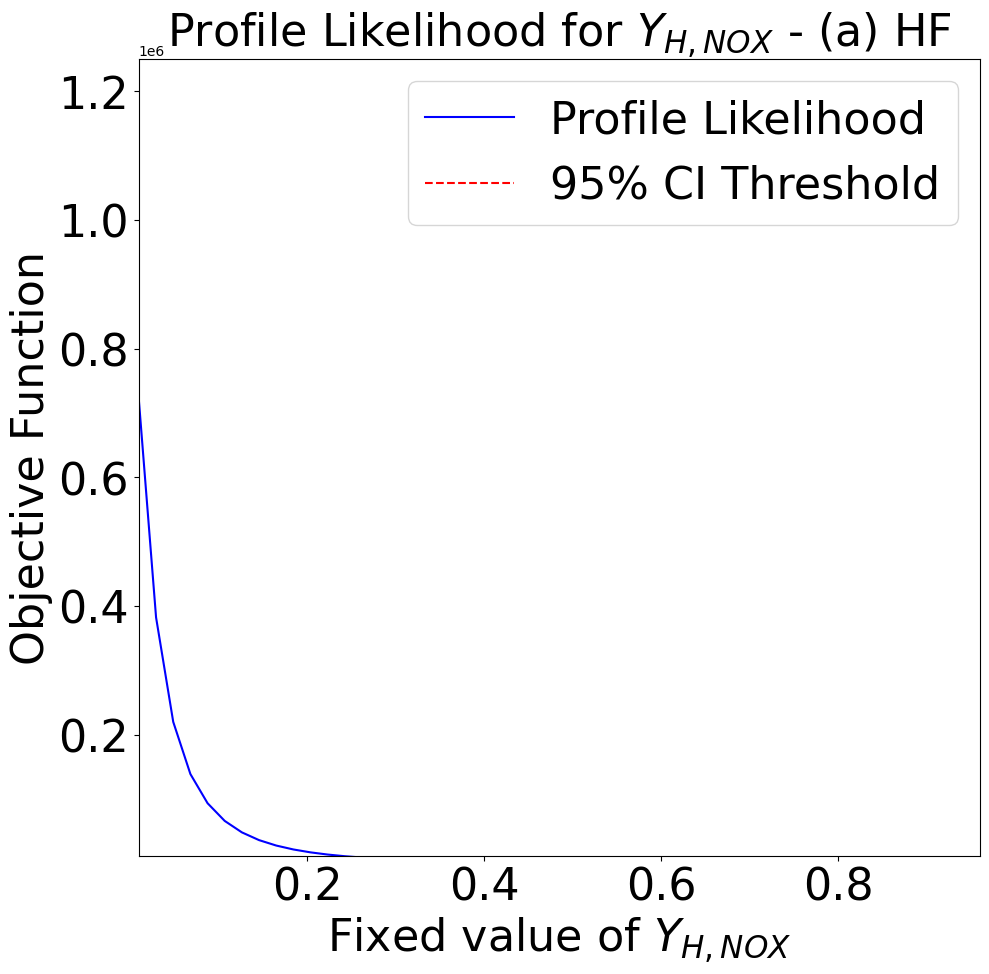

In [5]:
# Specifically for eta_NOX, plot the profile likelihood with the title "(a) HF Dataset" 
fontsize = 32
param_name = 'Y_H_NOX'
formatted_name = theta_format_names[param_name]
plt.figure(figsize=(10, 10))
plt.plot(fixed_values[param_name], obj_vals[param_name], linestyle='-', color='b', label='Profile Likelihood')
plt.axhline(CI_threshold[param_name], color='r', linestyle='--', label='95% CI Threshold')

plt.title(f"Profile Likelihood for {formatted_name} - (a) HF", fontsize=fontsize)
# plt.suptitle(f"Profile Likelihood for {formatted_name}", fontsize=fontsize)

plt.xlabel(f"Fixed value of {formatted_name}", fontsize=fontsize)
plt.ylabel('Objective Function', fontsize=fontsize)         
# Make x limit fit data
plt.xlim(left=min(fixed_values[param_name]), right=max(fixed_values[param_name]))
plt.ylim(bottom=1.175e4, top=1.25e6)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

In [6]:
# # ----------------------------------------------------------
# ## LASSO Correlations
# # ----------------------------------------------------------

# # Upper and lower bound for each non-identifiable parameter

# # The following parameters are identifiable from the PLA graphs:
#     # k_H, K_X, K_NOX, K_S, b_H_O2, b_STO_O2, mu_A, K_A_NH4, Y_STO_O2, Y_H_O2, Y_A
# # The others are non-identifiable: 
#     # k_STO, eta_NOX, K_O2, mu_H, K_A_O2, K_A_ALK, Y_STO_NOX, Y_H_NOX, i_N_BM,
# # Special cases (for those going to 0):
#     # K_STO, 

# # All points for non-identifiable parameters 
# non_iden_bounds = {
#     'k_STO' : (0, 100),
#     'eta_NOX': (0, 100),
#     'K_O2': (0, 100),
#     'mu_H': (0, 100),
#     'K_A_O2': (0, 100),
#     'K_A_ALK': (0, 100),
#     'Y_STO_NOX': (0, 100),
#     'Y_H_NOX': (0, 100),
#     'i_N_BM': (0, 100),
# }

# # Get fixed_values and corresponding theta_vals for each non-identifiable parameter within the bounds respectively
# non_iden_fixed_values = {}
# non_iden_theta_vals = {}
# for param, bounds in non_iden_bounds.items():
#     fixed_values_param = fixed_values[param]
#     theta_vals_param = theta_vals[param]
#     # Get the values and corresponding theta_vals within the bounds
#     filtered_fixed_values = []
#     filtered_theta_vals = []
#     for i, val in enumerate(fixed_values_param):
#         if bounds[0] <= val <= bounds[1]:
#             filtered_fixed_values.append(val)
#             filtered_theta_vals.append(theta_vals_param[i])
#     non_iden_fixed_values[param] = filtered_fixed_values
#     non_iden_theta_vals[param] = filtered_theta_vals

# lasso_results = {}
# non_identifiable_params = list(non_iden_bounds.keys())

# for target_param in non_identifiable_params:
#     print(f"\nFitting LASSO correlation for {target_param}...")

#     Y = np.array(non_iden_fixed_values[target_param])
#     theta_samples = non_iden_theta_vals[target_param]

#     # input_params = [p for p in all_param_idx if p != target_param and p not in params_to_always_fix] ---- Identifiable and non-identifiable params
#     input_params = [p for p in non_identifiable_params if p != target_param] # ---- Non-Identifiable params only
#     X = np.array([[theta[all_param_idx[p]] for p in input_params] for theta in theta_samples])
#     param_names_X = input_params

#     # Step 1: LassoCV for optimal λ and λ grid
#     lasso_cv = LassoCV(cv=5, random_state=seed).fit(X, Y)
#     optimal_lambda = lasso_cv.alpha_
#     lambda_grid = lasso_cv.alphas_
#     log_lambda_grid = -np.log10(lambda_grid)
#     cv_r2 = r2_score(Y, lasso_cv.predict(X))
#     cv_intercept = lasso_cv.intercept_
#     cv_coefficients = dict(zip(param_names_X, lasso_cv.coef_))

#     mse_list = []
#     r2_list = []
#     models = []

#     for alpha in lambda_grid:
#         model = Lasso(alpha=alpha, max_iter=10000)
#         model.fit(X, Y)
#         Y_pred = model.predict(X)
#         mse_list.append(mean_squared_error(Y, Y_pred))
#         r2_list.append(r2_score(Y, Y_pred))
#         models.append(model)

#     # Step 2: Best (lowest MSE) model
#     best_idx = np.argmin(mse_list)
#     best_lambda = lambda_grid[best_idx]
#     best_model = models[best_idx]
#     best_r2 = r2_list[best_idx]
#     best_intercept = best_model.intercept_
#     best_coefficients = dict(zip(param_names_X, best_model.coef_))

#     # Step 3: Store all results
#     lasso_results[target_param] = {
#         'lambdas': lambda_grid,
#         'log_lambdas': log_lambda_grid,
#         'models': models,
#         'mse_list': mse_list,
#         'r2_list': r2_list,
#         'cv_lambda': optimal_lambda,
#         'cv_log_lambda': -np.log10(optimal_lambda),
#         'cv_model': lasso_cv,
#         'cv_r2': cv_r2,
#         'cv_intercept': cv_intercept,
#         'cv_coefficients': cv_coefficients,
#         'best_lambda': best_lambda,
#         'best_log_lambda': -np.log10(best_lambda),
#         'best_model': best_model,
#         'best_intercept': best_intercept,
#         'best_coefficients': best_coefficients,
#         'best_r2': best_r2
#     }

#     # --------
#     # Best case equation
#     def format_equation(intercept, coefs, r2, label, target_param):
#         # Get formatted name for the target parameter
#         target_label = theta_format_names.get(target_param, target_param)
#         # Build the RHS terms of the equation
#         terms = []
#         for p, beta in coefs.items():
#             if abs(beta) > 1e-5:  # Only include non-zero coefficients
#                 param_label = theta_format_names.get(p, p)
#                 terms.append(f"{beta:.5f} × {param_label}")
#         # Construct equation string
#         equation = f"{target_label} ≈ {intercept:.5f}"
#         if terms:
#             equation += " + " + " + ".join(terms)
#         # Print the equation with R² value
#         print(f"\n{label} Equation (R² = {r2:.5f}):\n{equation}\n")


#     # Print the best case (lowest MSE) equation
#     format_equation(best_intercept, best_coefficients, best_r2, f"Best-Fit (−log₁₀(λ) = {-np.log10(best_lambda):.3f})", target_param)
#     # Print the LassoCV best case equation
#     format_equation(cv_intercept, cv_coefficients, cv_r2, f"LassoCV (−log₁₀(λ) = {-np.log10(optimal_lambda):.3f})", target_param)

#     # Manual lambdas
#     manual_log_lambdas = {
#         'K_X': 0,
#         'k_STO': -0.75,
#         'K_S': -0.75,
#         'mu_H': 2.5,
#         'mu_A': 1.0,
#         'K_A_NH4': 1.0,
#         'K_A_ALK': 2.5,
#         'Y_STO_O2': 4.0,
#         'Y_STO_NOX': 3.5,
#         'Y_H_O2': 3.0,
#         'Y_H_NOX': 3.5,
#         'Y_A': 4.3
#     }

#     chosen_log_lambda = manual_log_lambdas.get(target_param, None)
#     if chosen_log_lambda is not None:
#         manual_idx = np.argmin(np.abs(log_lambda_grid - chosen_log_lambda))
#         manual_lambda = lambda_grid[manual_idx]
#         manual_model = models[manual_idx]
#         manual_r2 = r2_list[manual_idx]
#         manual_intercept = manual_model.intercept_
#         manual_coefficients = dict(zip(param_names_X, manual_model.coef_))

#         # Store manual details
#         lasso_results[target_param].update({
#             'manual_log_lambda': chosen_log_lambda,
#             'manual_lambda': manual_lambda,
#             'manual_model': manual_model,
#             'manual_r2': manual_r2,
#             'manual_intercept': manual_intercept,
#             'manual_coefficients': manual_coefficients
#         })

#         # Manual equation
#         format_equation(manual_intercept, manual_coefficients, manual_r2, f"Manual (−log₁₀(λ) = {chosen_log_lambda:.3f})", target_param)

#         # Plot best, LassoCV, and manual results vs MSE
#         plt.figure(figsize=(8, 5))
#         plt.plot(log_lambda_grid, mse_list, label='Mean MSE (Training)', color='blue')
#         plt.axvline(-np.log10(optimal_lambda), color='red', linestyle='--', label='LassoCV λ')
#         plt.axvline(-np.log10(best_lambda), color='green', linestyle='--', label='Best MSE λ')
#         plt.axvline(chosen_log_lambda, color='orange', linestyle='--', label='Manual λ')
#         plt.title(f"−log₁₀(λ) vs MSE for {theta_format_names[target_param]}")
#         plt.xlabel("−log₁₀(λ)")
#         plt.ylabel("Mean Squared Error")
#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

#         # Plot best, LassoCV, and manual results vs R²
#         plt.figure(figsize=(8, 5))
#         plt.plot(log_lambda_grid, r2_list, label='R² (Training)', color='blue')
#         plt.axvline(-np.log10(optimal_lambda), color='red', linestyle='--', label='LassoCV λ')
#         plt.axvline(-np.log10(best_lambda), color='green', linestyle='--', label='Best MSE λ')
#         plt.axvline(chosen_log_lambda, color='orange', linestyle='--', label='Manual λ')
#         plt.axhline(0.95, color='black', linestyle='-', label='R² = 0.95')
#         plt.title(f"−log₁₀(λ) vs R² for {theta_format_names[target_param]}")
#         plt.xlabel("−log₁₀(λ)")
#         plt.ylabel("R²")
#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()
        

In [7]:

# # Initialize coefficient matrices
# lasso_best_matrix = []
# lasso_cv_matrix = []
# lasso_manual_matrix = []

# # Get list of all non-identifiable predictors (same for all equations)
# predictor_params = list(non_identifiable_params)


# for target_param in non_identifiable_params:
#     row_best = []
#     row_cv = []
#     row_manual = []

#     for predictor in predictor_params:
#         if predictor == target_param:
#             # row_best.append(0)
#             # row_cv.append(0)
#             # row_manual.append(0)
#             # continue
#             row_best.append(lasso_results[target_param]['best_intercept'])
#             row_cv.append(lasso_results[target_param]['cv_intercept'])
#             row_manual.append(lasso_results[target_param].get('manual_intercept', 0))
#             continue

#         best_coef = lasso_results[target_param]['best_coefficients'].get(predictor, 0)
#         cv_coef = lasso_results[target_param]['cv_coefficients'].get(predictor, 0)
#         manual_coef = lasso_results[target_param].get('manual_coefficients', {}).get(predictor, 0)

#         row_best.append(best_coef)
#         row_cv.append(cv_coef)
#         row_manual.append(manual_coef)

#     lasso_best_matrix.append(row_best)
#     lasso_cv_matrix.append(row_cv)
#     lasso_manual_matrix.append(row_manual)

# # Convert to DataFrames
# lasso_best_df = pd.DataFrame(lasso_best_matrix, index=non_identifiable_params, columns=predictor_params)
# lasso_cv_df = pd.DataFrame(lasso_cv_matrix, index=non_identifiable_params, columns=predictor_params)
# lasso_manual_df = pd.DataFrame(lasso_manual_matrix, index=non_identifiable_params, columns=predictor_params)

# # For plotting the coefficient matrices
# def plot_coefficient_matrix(df, title="LASSO Coefficient Matrix", figsize=(10, 8), fmt=".2f",
#                             cell_fontsize=10, header_fontsize=11, grey_threshold=0.01):
#     fig, ax = plt.subplots(figsize=figsize)
#     ax.axis('off')  # Hide axes

#     cell_text = [[format(val, fmt) for val in row] for row in df.values]
#     table = ax.table(
#         cellText=cell_text,
#         rowLabels=df.index,
#         colLabels=df.columns,
#         loc='center',
#         cellLoc='center'
#     )

#     table.auto_set_font_size(False)
#     table.set_fontsize(cell_fontsize)
#     table.scale(1.2, 1.2)

#     for (row, col), cell in table.get_celld().items():
#         if row == 0 or col == -1:
#             cell.set_text_props(fontsize=header_fontsize, weight='bold')
#             continue

#         value = df.iat[row - 1, col]
#         if row - 1 == col:  # diagonal → intercept
#             cell.set_facecolor('#FFEB3B')  # yellow
#         elif abs(value) < grey_threshold:
#             cell.set_facecolor('#DDDDDD')  # light grey

#     ax.set_title(title, fontsize=header_fontsize + 2, pad=20)

#     # Add legend
#     legend_elements = [
#         Patch(facecolor="#FFE600", edgecolor='black', label='Intercept (Diagonal)'),
#         Patch(facecolor='#DDDDDD', edgecolor='black', label=f'|coef| < {grey_threshold}'),
#         Patch(facecolor='white', edgecolor='black', label='Regular Coefficient')
#     ]
#     ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.15),
#               ncol=3, fontsize=cell_fontsize)

#     plt.tight_layout()
#     plt.show()


# # Rename indices and columns for better readability
# lasso_best_renamed_df = lasso_best_df.rename(index=theta_format_names, columns=theta_format_names)
# lasso_cv_renamed_df = lasso_cv_df.rename(index=theta_format_names, columns=theta_format_names)
# lasso_manual_renamed_df = lasso_manual_df.rename(index=theta_format_names, columns=theta_format_names)

# # plot coefficient matrix
# plot_coefficient_matrix(lasso_best_renamed_df, title="Best MSE LASSO Coefficients Matrix")
# plot_coefficient_matrix(lasso_cv_renamed_df, title="LassoCV Coefficients Matrix")
# plot_coefficient_matrix(lasso_manual_renamed_df, title="Manual Lambda Coefficients Matrix")

# """
# NAASI results:
# K_A_O2,		0.0524
# b_H_O2,		0.0525
# Y_H_NOX,	0.0683
# Y_STO_NOX,	0.0694
# K_A_ALK,	0.0741
# Y_A,		0.0846
# K_X,		0.1140
# K_A_NH4,	0.1330
# Y_STO_O2,	0.1682
# mu_A,		0.1739
# Y_H_O2,		0.1782
# mu_H,		0.2656
# k_H,		0.7316
# K_S,		0.8433
# k_STO,		1.0000

# """

# # Visualize smaller matrix with certain params columns and rows removed:
#     # Always in descending order of NAASI
# params_to_remove_dict = {
#     'k_H': non_identifiable_params.index('k_H'),
#     'k_STO': non_identifiable_params.index('k_STO'),
#     'mu_A': non_identifiable_params.index('mu_A'),
#     'K_A_NH4': non_identifiable_params.index('K_A_NH4'),
#     'Y_STO_NOX': non_identifiable_params.index('Y_STO_NOX'),
#     'Y_H_O2': non_identifiable_params.index('Y_H_O2'),
# }
# params_to_remove = list(params_to_remove_dict.keys())

# # Create a new DataFrame with the specified columns and rows removed
# lasso_best_small_df = lasso_best_df.drop(index=params_to_remove, columns=params_to_remove)
# lasso_cv_small_df = lasso_cv_df.drop(index=params_to_remove, columns=params_to_remove)
# lasso_manual_small_df = lasso_manual_df.drop(index=params_to_remove, columns=params_to_remove)

# # Renaming for readability
# lasso_best_small_renamed = lasso_best_small_df.rename(index=theta_format_names, columns=theta_format_names)
# lasso_cv_small_renamed = lasso_cv_small_df.rename(index=theta_format_names, columns=theta_format_names)
# lasso_manual_small_renamed = lasso_manual_small_df.rename(index=theta_format_names, columns=theta_format_names)

# # Display the smaller matrix -- Not for writing full equations, only usefull for double checking specificiability
# plot_coefficient_matrix(lasso_best_small_renamed, title="Best MSE LASSO (Reduced)")
# plot_coefficient_matrix(lasso_cv_small_renamed, title="LassoCV (Reduced)")
# plot_coefficient_matrix(lasso_manual_small_renamed, title="Manual Lambda (Reduced)")




In [8]:
# def analyze_specifiability_plain(coef_df, threshold=0.01):
#     from collections import defaultdict

#     # Build the dependency graph
#     graph = defaultdict(set)
#     params = coef_df.index.tolist()

#     for target in params:
#         for predictor in params:
#             if target == predictor:
#                 continue  # Skip diagonal, it is intercept
#             if abs(coef_df.loc[target, predictor]) >= threshold:
#                 graph[target].add(predictor)

#     visited = set()
#     temp_mark = set()
#     ordering = []

#     def visit(node):
#         if node in temp_mark:
#             raise ValueError("Cycle detected")
#         if node not in visited:
#             temp_mark.add(node)
#             for dep in graph[node]:
#                 visit(dep)
#             temp_mark.remove(node)
#             visited.add(node)
#             ordering.append(node)

#     try:
#         for node in params:
#             if node not in visited:
#                 visit(node)
#         return True, ordering
#     except ValueError:
#         return False, None


# def try_specifiability_with_removals(coef_df, sensitivity_order, verbose=True):
#     """
#     Tries to determine specifiability of a system by iteratively removing
#     parameters (highest NAASI first) until the system is acyclic.

#     Parameters:
#         coef_df (pd.DataFrame): full coefficient matrix
#         sensitivity_order (list of str): parameters sorted by descending NAASI
#         verbose (bool): if True, prints status messages

#     Returns:
#         tuple: (success: bool, ordering: list of parameters, removed_params: list)
#     """
#     removed = []
#     working_df = coef_df.copy()

#     for i in range(len(sensitivity_order) + 1):  # +1 to also try full matrix
#         is_specified, ordering = analyze_specifiability_plain(working_df)
        
#         if is_specified:
#             if verbose:
#                 print(f"\nSUCCESSS System is fully specified after removing {len(removed)} parameters.")
#                 if removed:
#                     print(f"Removed parameters: {removed}")
#                 else:
#                     print("No parameters removed.")
#                 print("Estimation order:")
#                 for j, param in enumerate(ordering, 1):
#                     print(f"{j}. {param}")
#             return True, ordering, removed
        
#         if i < len(sensitivity_order):
#             to_remove = sensitivity_order[i]
#             removed.append(to_remove)
#             working_df = working_df.drop(index=to_remove, columns=to_remove)
#         else:
#             break

#     if verbose:
#         print("\nFAIL Could not fully specify the system, even after removing all listed parameters.")
#         print(f"Parameters tried for removal: {removed}")
#     return False, None, removed

# # Your NAASI descending list
# naasi_order = [
#     "k_STO", "K_S", "k_H", "mu_H", "Y_H_O2", "mu_A", "Y_STO_O2", 
#     "K_A_NH4", "K_X", "Y_A", "K_A_ALK", "Y_STO_NOX", 
#     "Y_H_NOX", "b_H_O2", "K_A_O2"
# ]

# # Run on the manual matrix
# success, ordering, removed = try_specifiability_with_removals(lasso_best_df, naasi_order)


In [9]:
# from itertools import combinations
# from collections import defaultdict

# def analyze_specifiability_plain(coef_df, threshold=0.01):
#     graph = defaultdict(set)
#     params = coef_df.index.tolist()

#     for target in params:
#         for predictor in params:
#             if target == predictor:
#                 continue  # Skip diagonal, it is intercept
#             if abs(coef_df.loc[target, predictor]) >= threshold:
#                 graph[target].add(predictor)

#     visited = set()
#     temp_mark = set()
#     ordering = []

#     def visit(node):
#         if node in temp_mark:
#             raise ValueError("Cycle detected")
#         if node not in visited:
#             temp_mark.add(node)
#             for dep in graph[node]:
#                 visit(dep)
#             temp_mark.remove(node)
#             visited.add(node)
#             ordering.append(node)

#     try:
#         for node in params:
#             if node not in visited:
#                 visit(node)
#         return True, ordering
#     except ValueError:
#         return False, None


# def find_minimal_removals(coef_df, max_removals=4, verbose=True):
#     """
#     Tries all combinations of parameter removals up to max_removals
#     to determine the smallest set needed to make the system acyclic.

#     Returns:
#         (success: bool, ordering: list, removed: list)
#     """
#     all_params = coef_df.index.tolist()

#     for r in range(0, max_removals + 1):
#         for subset in combinations(all_params, r):
#             reduced_df = coef_df.drop(index=list(subset), columns=list(subset))
#             success, ordering = analyze_specifiability_plain(reduced_df)
#             if success:
#                 if verbose:
#                     print(f"\n SUCCESS Fully specified after removing {len(subset)} parameter(s): {list(subset)}")
#                     print("Estimation order:")
#                     for i, p in enumerate(ordering, 1):
#                         print(f"{i}. {p}")
#                 return True, ordering, list(subset)

#     if verbose:
#         print(f"\n FAIL Could not fully specify the system after testing up to {max_removals} removals.")
#     return False, None, []

# # Try on your matrix
# success, ordering, removed = find_minimal_removals(lasso_best_df, max_removals=7)


# Alternative - PCA

Idea: Instead of using LASSO, we can use PCA to identify the most important latent variables that explain the variance in the non-identifiable parameters. 
Then, we can use these latent variables to model the non-identifiable parameters as linear combinations of the latent variables.

1) Create X matrix of all non-identifiable parameter values from PLA
X = [ [K_X fixed] [k_STO -> Y_A optimized]
      [K_X theta optimized] [k_STO fixed] [K_S -> Y_A theta optimized] ]
 ...
 X is a matrix with all fixed and optimized parameters in one large matrix
 Should be done in the order of the non-identifiable parameters

2) Standardize X matrix
X_std = (X - mean) / std

3) Perform PCA on X_std

4) Select the number of components that explain at least 95% of the variance

5) Create a new matrix with the selected components

6) Save PCA results for use in MCMC
pca_results = {
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'eigenvectors': eigenvectors,
    'eigenvalues': eigenvalues,
    'non_iden_params': non_iden_params,
    'n_components': n_components,
    'param_names': non_iden_params,
}
# ----------------------------------------------------------

For MCMC:
1) Specify num_components amount of latent variables z, normal distribution with mean 0 and std 1
    z = pymc.Normal("z", mu=0, sigma=1, shape=n_pca_components) # normal priors on latent PCA space
2) Affine transofrm: Map from latent space back to standardized parameter space
    theta_std_pca = pt.dot(eigenvectors_transposed, z) 
3) Inverse standardization
    theta_pca = theta_std_pca * scale_pt + mean_pt
4) Ensure theta_pca has all positive values
     Potential adds constraint that adjusts probability density
     pymc.Potential("theta_pca_positive", pt.switch(
         pt.all(theta_pca > 0), # Ensure all parameters are positive
         0, # No penalty if all parameters are positive, log(1) = 0
         -np.inf # Negative infinity if any parameter is negative (log likelihood will be zero)
         ))  

5) Define Non-identifiable parameters
    k_STO = pymc.Deterministic("k_STO", theta_pca[0])
    eta_NOX = pymc.Deterministic("eta_NOX", theta_pca[1])
    K_O2 = pymc.Deterministic("K_O2", theta_pca[2])
    mu_H = pymc.Deterministic("mu_H", theta_pca[3])
    ....
    OR
    Using order of pca_param_names to define the order of the parameters in theta_pca
    k_STO = pymc.Deterministic("k_STO", theta_pca[param_names.index("k_STO")])
    eta_NOX = pymc.Deterministic("eta_NOX", theta_pca[param_names.index("eta_NOX")])
    K_O2 = pymc.Deterministic("K_O2", theta_pca[param_names.index("K_O2")])
    ...


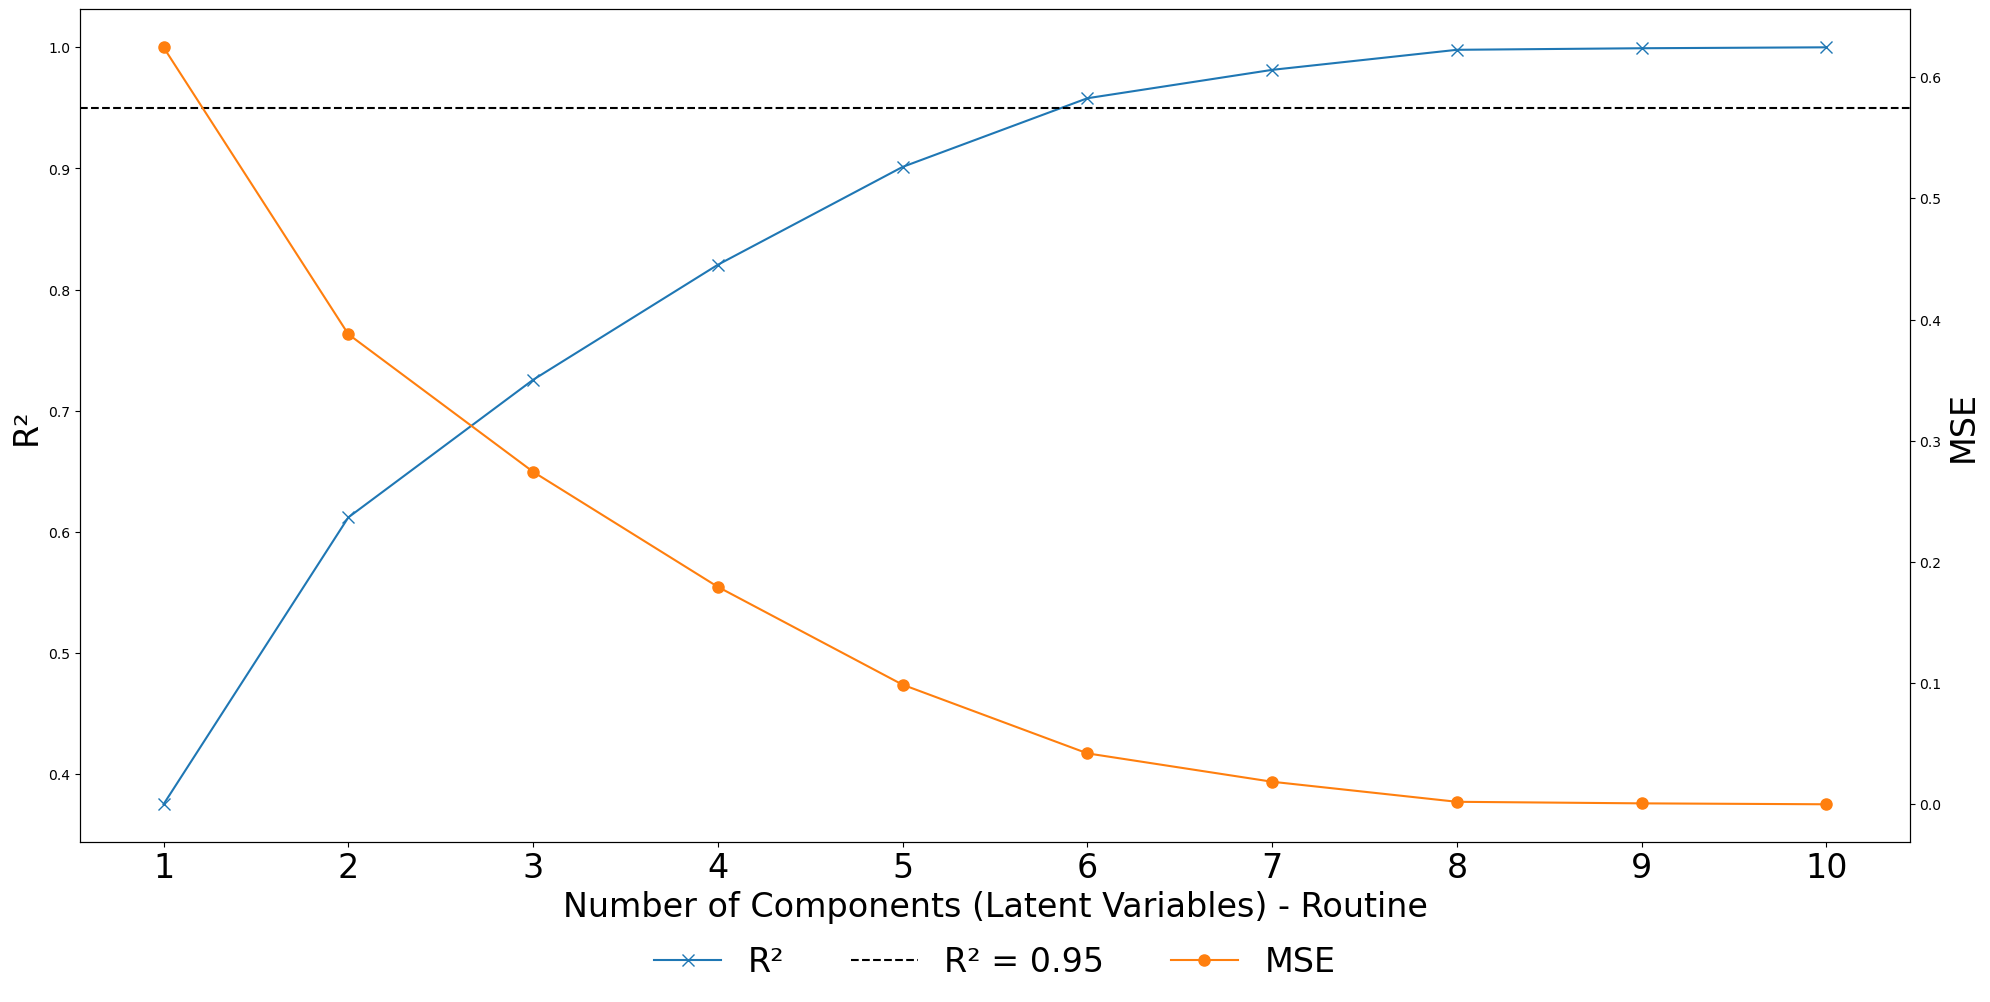

Final PCA with 8 components:
Mean Squared Error (MSE): 0.0021
R²: 0.9979
Parameters used in PCA:
- k_STO
- eta_NOX
- K_NOX
- K_S
- mu_A
- K_A_NH4
- K_A_O2
- K_A_ALK
- Y_H_NOX
- Y_A
PCA results saved to c:\Users\ruanv\OneDrive - Stellenbosch University\University\Masters\Documents - Machine Learning at Process Engineering\Post-graduate students\Ruan van den Berg\Code\ThesisASM3\RunTemplate\4-Correlations\Results\PCA_Results.pkl


In [ ]:
# ----------------------------------------------------------
## PCA for correlation
# ----------------------------------------------------------

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score


"""
Parameters to always fix based on NAASI results (Param, fixed value):
    i_SS_BM:    0.9
    i_SS_X_I:    0.75
    i_SS_X_S:    0.75
    f_S_I:    1e-06
    i_N_S_I:    0.01
    K_NH4:    0.01
    i_N_X_I:    0.04
    i_N_S_S:    0.03
    K_ALK:    0.1
    K_STO:    0.1
    b_A_NOX:    0.1
    i_N_X_S:    0.03
    b_H_NOX:    0.15
    b_STO_NOX:    0.15
    f_X_I:    0.2
    b_A_O2:    0.2
    i_N_BM:    0.07
    K_O2:    0.2
"""

# The following parameters are fixed to prior means:
    # i_SS_BM, i_SS_X_I, i_SS_X_S, f_S_I, i_N_S_I, K_NH4, i_N_X_I, i_N_S_S, K_ALK, K_STO, b_A_NOX, i_N_X_S, b_H_NOX, b_STO_NOX, f_X_I, b_A_O2, i_N_BM, K_O2
# The following parameters are identifiable from the PLA graphs:
    #  k_H, k_STO, eta_NOX, K_S, mu_H, b_H_O2, b_STO_O2, mu_A, K_A_NH4, K_A_O2, K_A_ALK, Y_STO_O2, Y_STO_NOX, Y_H_O2, Y_A
# The others are non-identifiable: 
    #  K_X, K_NOX, Y_H_NOX, 
# Special cases (for those going to 0):
    # None

# TODO: Must be MAUNAL based on plots!
    # Bounds can be set to 0 and 100 to cover all possible values of non-identifiable parameters

    # params: k_STO, eta_NOX, K_NOX, K_S, mu_A, K_A_NH4, K_A_O2, K_A_ALK, Y_H_NOX, Y_A
non_iden_bounds = {
    # 'K_X': (0, 100), example
    "k_STO" : (0, 100),
    "eta_NOX": (0, 100),
    "K_NOX": (0, 100),
    "K_S": (0, 100),
    "mu_A": (0, 100),
    "K_A_NH4": (0, 100),
    "K_A_O2": (0, 100),
    "K_A_ALK": (0, 100),
    "Y_H_NOX": (0, 100),
    "Y_A": (0, 100),
}
case_name = "Routine"
n_components = 8  # <-- Adjust after checking the plot

# ----------------------------------------------------
non_iden_params = list(non_iden_bounds.keys())

# Results file path (ensure directory exists)
pca_results_dir = top_dir / "4-Correlations" / "Results"
pca_results_dir.mkdir(parents=True, exist_ok=True)
pca_results_file = pca_results_dir / "PCA_Results.pkl"

# === Early exit if nothing to do ===
if len(non_iden_params) == 0:
    pca_results = {
        'scaler_mean': np.array([]),
        'scaler_scale': np.array([]),
        'eigenvectors': np.empty((0, 0)),
        'eigenvalues': np.array([]),
        'non_iden_params': [],
        'n_components': 0,
        'param_names': [],
    }
    with open(pca_results_file, 'wb') as f:
        pickle.dump(pca_results, f)
    print("No non-identifiable parameters provided; PCA skipped.")
    print(f"PCA results saved to {pca_results_file}")
else:
    # ---------- Build filtered datasets ----------
    non_iden_fixed_values = {}
    non_iden_theta_vals = {}
    for param, bounds in non_iden_bounds.items():
        fixed_values_param = fixed_values[param]
        theta_vals_param = theta_vals[param]
        filtered_fixed_values = []
        filtered_theta_vals = []
        for i, val in enumerate(fixed_values_param):
            if bounds[0] <= val <= bounds[1]:
                filtered_fixed_values.append(val)
                filtered_theta_vals.append(theta_vals_param[i])
        non_iden_fixed_values[param] = filtered_fixed_values
        non_iden_theta_vals[param] = filtered_theta_vals

    # ---------- Assemble X matrix ----------
    X = []
    for fixed_param in non_iden_fixed_values:
        fixed_vals = non_iden_fixed_values[fixed_param]
        theta_vals_for_param = non_iden_theta_vals[fixed_param]
        j = non_iden_params.index(fixed_param)
        for i in range(len(fixed_vals)):
            row = [None] * len(non_iden_params)
            row[j] = fixed_vals[i]
            opt_idx = 0
            for k, param in enumerate(non_iden_params):
                if k != j:
                    row[k] = theta_vals_for_param[i][opt_idx]
                    opt_idx += 1
            X.append(row)

    X = np.array(X, dtype=float)

    # Safety: if filtering resulted in no rows, skip
    if X.size == 0:
        pca_results = {
            'scaler_mean': np.array([]),
            'scaler_scale': np.array([]),
            'eigenvectors': np.empty((0, 0)),
            'eigenvalues': np.array([]),
            'non_iden_params': non_iden_params,
            'n_components': 0,
            'param_names': non_iden_params,
        }
        with open(pca_results_file, 'wb') as f:
            pickle.dump(pca_results, f)
        print("Non-identifiable bounds yielded no samples; PCA skipped.")
        print(f"PCA results saved to {pca_results_file}")
    else:
        # ---------- Standardize ----------
        scaler = StandardScaler()
        X_std = scaler.fit_transform(X)

        # ---------- Full PCA for diagnostics ----------
        pca = PCA()
        X_pca = pca.fit_transform(X_std)

        mse_list, r2_list = [], []
        for i in range(1, len(non_iden_params) + 1):
            X_reduced = X_pca[:, :i]
            model = LinearRegression()
            model.fit(X_reduced, X_std)
            X_reconstructed = model.predict(X_reduced)
            mse_list.append(mean_squared_error(X_std, X_reconstructed))
            r2_list.append(r2_score(X_std, X_reconstructed, multioutput='variance_weighted'))

        # --- Diagnostic plot ---
        fontsize = 24
        fig, ax1 = plt.subplots(figsize=(20, 10))

        # Left y-axis: R²
        ax1.set_xlabel(f'Number of Components (Latent Variables) - {case_name}', fontsize=fontsize)
        ax1.set_ylabel('R²', fontsize=fontsize)
        ax1.plot(range(1, len(r2_list) + 1), r2_list, color='C0', label='R²', marker='x', markersize=8)
        ax1.tick_params(axis='y',)
        # make sure only interger x-ticks
        ax1.set_xticks(range(1, len(non_iden_params) + 1))
        ax1.tick_params(axis='x', labelsize=fontsize)
        ax1.axhline(0.95, color='black', linestyle='--', label='R² = 0.95')

        # Right y-axis: MSE
        ax2 = ax1.twinx()
        ax2.set_ylabel('MSE', fontsize=fontsize)
        ax2.plot(range(1, len(mse_list) + 1), mse_list, color='C1', label='MSE', marker='o', markersize=8)
        ax2.tick_params(axis='y',)

        # Combine legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, fontsize=fontsize, loc='lower center',
                    ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.2))

        fig.tight_layout()
        plt.show()

        # ---------- Choose components (set n_components as needed) ----------

        # Final PCA and metrics
        if n_components > 0:
            pca_final = PCA(n_components=n_components)
            X_pca_final = pca_final.fit_transform(X_std)
            eigenvectors = pca_final.components_
            eigenvalues = pca_final.explained_variance_
            model = LinearRegression()
            model.fit(X_pca_final, X_std)
            X_reconstructed_final = model.predict(X_pca_final)
            mse_final = mean_squared_error(X_std, X_reconstructed_final)
            r2_final = r2_score(X_std, X_reconstructed_final, multioutput='variance_weighted')
            print(f"Final PCA with {n_components} components:")
            print(f"Mean Squared Error (MSE): {mse_final:.4f}")
            print(f"R²: {r2_final:.4f}")
        else:
            # If zero components selected, store empties consistently
            eigenvectors = np.empty((0, len(non_iden_params)))
            eigenvalues = np.array([])

        # ---------- Save results ----------
        pca_results = {
            'scaler_mean': scaler.mean_ if 'scaler' in locals() else np.array([]),
            'scaler_scale': scaler.scale_ if 'scaler' in locals() else np.array([]),
            'eigenvectors': eigenvectors,
            'eigenvalues': eigenvalues,
            'non_iden_params': non_iden_params,
            'n_components': n_components,
            'param_names': non_iden_params,
        }

        with open(pca_results_file, 'wb') as f:
            pickle.dump(pca_results, f)

        print("Parameters used in PCA:")
        for param in non_iden_params:
            print(f"- {param}")
        print(f"PCA results saved to {pca_results_file}")

In [11]:
## TODO: MANUAL

# The following parameters are fixed to prior means:
    # i_SS_BM, i_SS_X_I, i_SS_X_S, f_S_I, i_N_S_I, K_NH4, i_N_X_I, i_N_S_S, K_ALK, K_STO, b_A_NOX, i_N_X_S, b_H_NOX, b_STO_NOX, f_X_I, b_A_O2, i_N_BM, K_O2
# The following parameters are identifiable from the PLA graphs:
    #  k_H, k_STO, eta_NOX, K_NOX, K_S, mu_H, b_H_O2, b_STO_O2, mu_A, K_A_NH4, K_A_O2, K_A_ALK, Y_STO_O2, Y_STO_NOX, Y_H_O2, Y_H_NOX, Y_A
# The others are non-identifiable: 
    #  None
# Special cases (for those going to 0):
    # None


fixed_params_list = [
    'i_SS_BM', 'i_SS_X_I', 'i_SS_X_S', 'f_S_I', 'i_N_S_I',
    'K_NH4', 'i_N_X_I', 'i_N_S_S', 'K_ALK', 'K_STO',
    'b_A_NOX', 'i_N_X_S', 'b_H_NOX', 'b_STO_NOX', 'f_X_I',
    'b_A_O2', 'i_N_BM', 'K_O2'
]

identifiable_params_list = [
    'k_H', 'K_X', 'k_STO', 'eta_NOX', 'K_NOX', 'K_S', 'mu_H', 
    'b_H_O2', 'b_STO_O2', 'mu_A', 'K_A_NH4',
    'K_A_O2', 'K_A_ALK', 'Y_STO_O2', 'Y_STO_NOX',
    'Y_H_O2', 'Y_H_NOX', 'Y_A'
]

non_identfiable_params_list = [
    
]

special_case_params_list = [
    
]

# Save Correlations csv file that lists fixed, identifiable, non-identifiable and special case parameters
correlations_data = {
    'Fixed Parameters': fixed_params_list,
    'Identifiable Parameters': identifiable_params_list,
    'Non-Identifiable Parameters': non_identfiable_params_list,
    'Special Case Parameters': special_case_params_list
}

correlations_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in correlations_data.items()]))
correlations_file = top_dir / "4-Correlations" / "Results" / "Parameters_lists.csv"
correlations_df.to_csv(correlations_file, index=False)